In [1]:
import pandas as pd  # Data manipulation
import pytz  # Time zones
import re  # Regular expressions
from tqdm import tqdm  # Progress bars
import random  # Random values
import numpy as np
import seaborn as sns
import re

import nltk  # Natural language processing
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA  # Sentiment analysis
nltk.download('vader_lexicon')  # Download VADER lexicon
from nltk.corpus import stopwords  # Stopwords
nltk.download('stopwords')  # Download stopwords corpus

from wordcloud import WordCloud  # Word cloud
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt  # Plotting
import seaborn as sns  # Statistical data visualization
import plotly.express as px  # Interactive plotting
import plotly.subplots as sp 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, scale
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import LatentDirichletAllocation

#import pyclustertend
#from pyclustertend import hopkins

# for DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\veena\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\veena\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Source of data: https://www.kaggle.com/datasets/curiel/rtechnology-posts-and-comments/data

In [3]:
import os
import datetime
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile

def download_dataset(dataset_path):
    # Initialize Kaggle API
    api = KaggleApi()
    api.authenticate()
    
    # Define the download path and filename
    download_path = './'
    zip_file = f'{dataset_path.split("/")[-1]}.zip'

    # Download dataset files to the current working directory
    api.dataset_download_files(dataset_path, path=download_path, unzip=False)

    # Define the CSV filename with today's date extension
    today = datetime.datetime.now().strftime('%Y-%m-%d')
    csv_filename = f'data_{today}.csv'

        # Assume the main file is named 'data.csv' and rename it
    os.rename(os.path.join(download_path, 'data.csv'),
                  os.path.join(download_path, csv_filename))

    print(f'Dataset downloaded and saved as {csv_filename}')


In [4]:
download_dataset('curiel/rtechnology-posts-and-comments')

Dataset URL: https://www.kaggle.com/datasets/curiel/rtechnology-posts-and-comments
Dataset downloaded and saved as data_2024-04-30.csv


In [8]:
from google.cloud import storage
from google.oauth2 import service_account
# Initialize Google Cloud Storage client
def upload_to_gcs(bucket_name, blob_prefix, local_directory='./'):
    

    # Path to your service account key file
    service_account_path = 'gc_key.json'

    # Create a credentials object from the service account file
    credentials = service_account.Credentials.from_service_account_file(service_account_path)

    # Use these credentials to initialize a Google Cloud Storage client
    storage_client = storage.Client(credentials=credentials)
    #storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)

    # Get today's date to define the CSV file
    today = datetime.datetime.now().strftime('%Y-%m-%d')
    local_file = f'data_{today}.csv'
    local_file_path = os.path.join(local_directory, local_file)

    # Define the blob (file) path in the bucket
    blob_path = os.path.join(blob_prefix, local_file)
    blob = bucket.blob(blob_path)

    # Upload the file
    blob.upload_from_filename(local_file_path)
    print(f"Uploaded {local_file} to {blob_path}")

    # Delete the local file after successful upload
    #os.remove(local_file_path)
    #print(f"Deleted local file {local_file_path} after successful upload.")

# Use the function
bucket_name = 'technology_subreddit'
blob_prefix = 'tech_data'

# Call the function to upload the file
upload_to_gcs(bucket_name, blob_prefix)

Uploaded data_2024-04-30.csv to tech_data\data_2024-04-30.csv


In [2]:
# input_df = pd.read_csv('data.csv')

In [3]:
# input_df.columns

Index(['register_index', 'post_id', 'comment_id', 'author', 'datetime',
       'title', 'url', 'score', 'comments', 'text', 'author_post_karma',
       'tag'],
      dtype='object')

## Data description: 

register_index: Unique identifier for data entry, can be removed

post_id: Identifier for posts in r/Technology, this is part of the primary key and shouldn't be deleted 

comment_id: Identifier for comments in posts, this is part of the primary key and shouldn't be deleted 

author: Username or pseudonym of the contributor 

datetime: Timestamp of post or comment creation 

title: Post title summarizing the topic 

url: Web address associated with the post 

score: Rating or score received by the post 

comments: Total number of comments on the post 

text: Content of the post or comment

tag: tags associated with the post

Important Note: The dataset contains some important information regarding the columns 'title' and 'comments'. It's important to understand their values in order to interpret the data correctly.

In the 'title' column, there may be a significant number of null values. A null value in this column indicates that the corresponding row pertains to a comment rather than a post. To identify the relationship between comment rows and their associated posts, you can examine the 'post_id' column. Rows with the same 'post_id' value refer to comments that are associated with the post identified by that 'post_id'.

Similarly, in the 'comments' column, the presence or absence of null values is crucial for determining whether a row represents a comment or a post. If the 'comments' column is null, it signifies a comment row. Conversely, if the 'comments' column is populated (including cases where the value is 0), it indicates a post row.

In [4]:
# Creating a copy of the dataframe for reference
working_df = input_df.copy()

# Dropping 'register_index' column
working_df = working_df.drop(columns=['register_index'])

In [5]:
# Checking and removing duplicates

# Original dataset count
print("Before deduplication shape:")
print(working_df.shape)  

# Performing deduplication
working_df_dedup = working_df.drop_duplicates()

# Deduplicated dataset
print("\nAfter deduplication shape:")
print(working_df_dedup.shape)

# No duplicates

Before deduplication shape:
(1430446, 11)

After deduplication shape:
(1430446, 11)


In [6]:
# Function to count missing values (including NA, NaNs, and 0)
def count_missing(df):
    missing_counts = df.isna().sum()  # Count of missing values
    missing_counts = missing_counts.add(df.eq(0).sum(), axis=0)  # Count of zeros
    return missing_counts

# Printing the counts of missing values
missing_value_counts = count_missing(working_df_dedup.copy())
print(missing_value_counts)

# there are several missing values (na/nan) and 0s but this is due to the structure of the dataset
# we will deal with them step by step

post_id                    0
comment_id             14950
author                     0
datetime                   0
title                1415496
url                  1415496
score                  75715
comments             1416547
text                       0
author_post_karma    1263688
tag                       25
dtype: int64


### Posts and comments split

In [7]:
# Converting datetime column to pandas datetime format
working_df_dedup['datetime'] = pd.to_datetime(working_df_dedup['datetime'])

# Extracting the date part from the 'datetime' column
working_df_dedup['date'] = working_df_dedup['datetime'].dt.date

In [8]:
# Extracting posts as separate df
# This logic ensures that all posts, regardless of whether they have associated comments or not, 
# are captured in a separate by filtering based on the presence of values in the 'title' column
working_df_dedup_post = working_df_dedup[working_df_dedup['title'].notnull()]
working_df_dedup_post = working_df_dedup_post.drop_duplicates()

# Extracting comments as separate df
# Comments are rows without a title
# As specified earlier, a null value in title indicates that the corresponding row pertains to a comment rather than a post
working_df_dedup_comment = working_df_dedup[working_df_dedup['title'].isnull()]
working_df_dedup_comment = working_df_dedup_comment.drop_duplicates()

## Posts data analysis

In [9]:
# Adding a new column 'has_comments_flag' to indicate whether the post has comments
working_df_dedup_post['has_comments_flag'] = working_df_dedup_post['comments'].notnull() & (working_df_dedup_post['comments'] > 0)

# Converting boolean values to 1s and 0s
working_df_dedup_post['has_comments_flag'] = working_df_dedup_post['has_comments_flag'].astype(int)

# Checking
working_df_dedup_post.head()


post_id comment_id             author            datetime  \
0    145k12d        NaN            SauloJr 2023-06-09 23:17:15   
125  145g5xf        NaN     lily__brunette 2023-06-09 20:40:07   
348  145f8kv        NaN  thebelsnickle1991 2023-06-09 20:03:31   
431  1447cts        NaN            ionedew 2023-06-08 12:01:58   
455  145xmyx        NaN          dasun0218 2023-06-10 11:17:50   

                                                 title  \
0    Reddit CEO Spez answered a grand total of 14 q...   
125  Reddit CEO Steve Huffman defends API changes i...   
348  Netflix's password crackdown leads to massive ...   
431  Sam Altman says he worries making ChatGPT was ...   
455  16 Game-Changing AI Tools: Unleashing the Futu...   

                                                   url  score  comments  \
0    https://www.reddit.com/r/technology/comments/1...    1.0       0.0   
125  https://www.reddit.com/r/technology/comments/1...  859.0     232.0   
348  https://www.reddit.com/r/technology/comments/1...    0.0      14.0   
431  https://www.reddit.com/r/technology/comments/1...    3.0      10.0   
455  https://www.reddit.com/r/technology/comments/1...    3.0       0.0   

                                                  text  author_post_karma  \
0    Reddit CEO Spez answered a grand total of 14 q...            44092.0   
125  Reddit CEO Steve Huffman defends API changes i...              542.0   
348  Netflix s password crackdown leads to massive ...           176771.0   
431  Sam Altman says he worries making ChatGPT was ...              466.0   
455  16 Game Changing AI Tools  Unleashing the Futu...              477.0   

                         tag        date  has_comments_flag  
0               Social Media  2023-06-09                  0  
125             Social Media  2023-06-09                  1  
348                 Business  2023-06-09                  1  
431  Artificial Intelligence  2023-06-08                  1  
455  Artificial Intelligence  2023-06-10                  0

In [10]:
working_df_dedup_post.head()

post_id comment_id             author            datetime  \
0    145k12d        NaN            SauloJr 2023-06-09 23:17:15   
125  145g5xf        NaN     lily__brunette 2023-06-09 20:40:07   
348  145f8kv        NaN  thebelsnickle1991 2023-06-09 20:03:31   
431  1447cts        NaN            ionedew 2023-06-08 12:01:58   
455  145xmyx        NaN          dasun0218 2023-06-10 11:17:50   

                                                 title  \
0    Reddit CEO Spez answered a grand total of 14 q...   
125  Reddit CEO Steve Huffman defends API changes i...   
348  Netflix's password crackdown leads to massive ...   
431  Sam Altman says he worries making ChatGPT was ...   
455  16 Game-Changing AI Tools: Unleashing the Futu...   

                                                   url  score  comments  \
0    https://www.reddit.com/r/technology/comments/1...    1.0       0.0   
125  https://www.reddit.com/r/technology/comments/1...  859.0     232.0   
348  https://www.reddit.com/r/technology/comments/1...    0.0      14.0   
431  https://www.reddit.com/r/technology/comments/1...    3.0      10.0   
455  https://www.reddit.com/r/technology/comments/1...    3.0       0.0   

                                                  text  author_post_karma  \
0    Reddit CEO Spez answered a grand total of 14 q...            44092.0   
125  Reddit CEO Steve Huffman defends API changes i...              542.0   
348  Netflix s password crackdown leads to massive ...           176771.0   
431  Sam Altman says he worries making ChatGPT was ...              466.0   
455  16 Game Changing AI Tools  Unleashing the Futu...              477.0   

                         tag        date  has_comments_flag  
0               Social Media  2023-06-09                  0  
125             Social Media  2023-06-09                  1  
348                 Business  2023-06-09                  1  
431  Artificial Intelligence  2023-06-08                  1  
455  Artificial Intelligence  2023-06-10                  0

In [122]:
working_df_dedup_post.shape

(14950, 15)

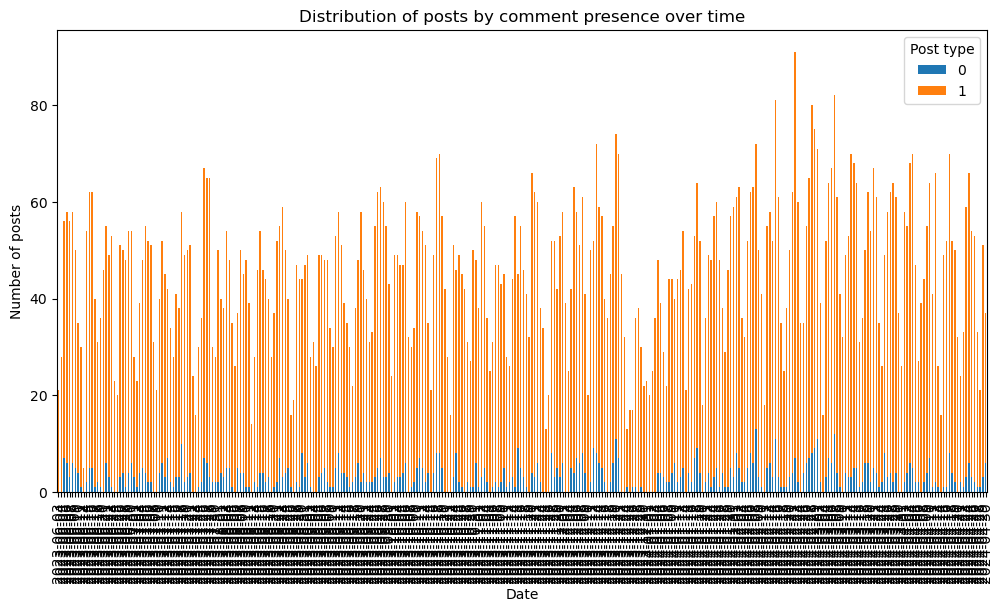

In [11]:
# Grouping data by date and has_comment_flag and counting rows
post_volume_over_time = working_df_dedup_post.groupby(['date', 'has_comments_flag']).size().unstack(fill_value=0)

# Plotting the stacked bar chart
post_volume_over_time.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Distribution of posts by comment presence over time')
plt.xlabel('Date')
plt.ylabel('Number of posts')
plt.legend(title='Post type')
plt.show()

# too cluttered

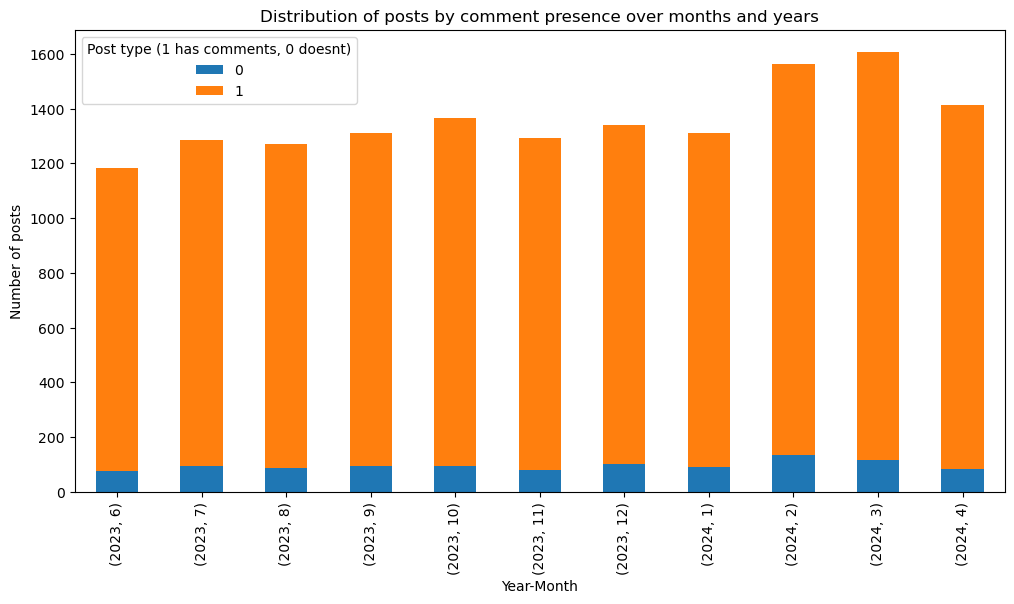

In [12]:
# Extracting year and month from the datetime column
working_df_dedup_post['year'] = working_df_dedup_post['datetime'].dt.year
working_df_dedup_post['month'] = working_df_dedup_post['datetime'].dt.month

# Grouping data by year, month, and has_comment_flag and counting rows
post_volume_over_mthyr = working_df_dedup_post.groupby(['year', 'month', 'has_comments_flag']).size().unstack(fill_value=0)

# Plotting the stacked bar chart
post_volume_over_mthyr.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Distribution of posts by comment presence over months and years')
plt.xlabel('Year-Month')
plt.ylabel('Number of posts')
plt.legend(title='Post type (1 has comments, 0 doesnt)')
plt.show()


In [13]:
# Grouping data by year, month, and has_comment_flag and counting rows
post_volume_over_time_tab = working_df_dedup_post.groupby(['year', 'month', 'has_comments_flag']).size().unstack(fill_value=0)

# Resetting index to make year and month columns accessible
post_volume_over_time_tab = post_volume_over_time_tab.reset_index()

# Renaming the columns for clarity
post_volume_over_time_tab.columns.name = None
post_volume_over_time_tab.rename(columns={True: 'Posts with comments', False: 'Posts without comments'}, inplace=True)

# Displaying the tabular summary
print("Tabular summary of post volume by comment presence over time:\n")
print(post_volume_over_time_tab)

Tabular summary of post volume by comment presence over time:

    year  month  Posts without comments  Posts with comments
0   2023      6                      76                 1109
1   2023      7                      94                 1193
2   2023      8                      86                 1184
3   2023      9                      96                 1216
4   2023     10                      93                 1275
5   2023     11                      81                 1212
6   2023     12                     102                 1239
7   2024      1                      91                 1220
8   2024      2                     134                 1429
9   2024      3                     116                 1492
10  2024      4                      82                 1330


In [14]:
# Calculating the total number of posts for each year and month
post_volume_over_time_tab['Total posts'] = post_volume_over_time_tab['Posts with comments'] + post_volume_over_time_tab['Posts without comments']

# Calculating the percentage of posts without comments for each year and month
post_volume_over_time_tab['% Posts without comments'] = (post_volume_over_time_tab['Posts without comments'] / post_volume_over_time_tab['Total posts']) * 100

# Calculating the total percentage of posts without comments across all data
total_posts = post_volume_over_time_tab['Posts without comments'].sum()
total_comments = post_volume_over_time_tab['Total posts'].sum()
total_percentage = (total_posts / total_comments) * 100

# Displaying the tabular summary with the percentages
print("Tabular summary of post volume by comment presence over time:\n")
print(post_volume_over_time_tab)
print("\nTotal percentage of posts without comments across time: {:.2f}%".format(total_percentage))


Tabular summary of post volume by comment presence over time:

    year  month  Posts without comments  Posts with comments  Total posts  \
0   2023      6                      76                 1109         1185   
1   2023      7                      94                 1193         1287   
2   2023      8                      86                 1184         1270   
3   2023      9                      96                 1216         1312   
4   2023     10                      93                 1275         1368   
5   2023     11                      81                 1212         1293   
6   2023     12                     102                 1239         1341   
7   2024      1                      91                 1220         1311   
8   2024      2                     134                 1429         1563   
9   2024      3                     116                 1492         1608   
10  2024      4                      82                 1330         1412   

    % Posts 

### Around 7% of the posts are orphan posts (posts without comments), these can be removed since there's no engagement in these posts

In [16]:
# Filtering out posts that don't have any comments using the has_comments_flag column
posts_with_comments_only = working_df_dedup_post[working_df_dedup_post['has_comments_flag'] == 1]
posts_with_comments_only.head()

post_id comment_id             author            datetime  \
125  145g5xf        NaN     lily__brunette 2023-06-09 20:40:07   
348  145f8kv        NaN  thebelsnickle1991 2023-06-09 20:03:31   
431  1447cts        NaN            ionedew 2023-06-08 12:01:58   
456  145vqmz        NaN             Majnum 2023-06-10 09:31:26   
509  1466uyt        NaN             777fer 2023-06-10 18:05:28   

                                                 title  \
125  Reddit CEO Steve Huffman defends API changes i...   
348  Netflix's password crackdown leads to massive ...   
431  Sam Altman says he worries making ChatGPT was ...   
456  Recent Mars Research Reveals New Discoveries a...   
509  There's been a whopping 736 Tesla crashes invo...   

                                                   url  score  comments  \
125  https://www.reddit.com/r/technology/comments/1...  859.0     232.0   
348  https://www.reddit.com/r/technology/comments/1...    0.0      14.0   
431  https://www.reddit.com/r/technology/comments/1...    3.0      10.0   
456  https://www.reddit.com/r/technology/comments/1...   15.0       2.0   
509  https://www.reddit.com/r/technology/comments/1...   26.0      19.0   

                                                  text  author_post_karma  \
125  Reddit CEO Steve Huffman defends API changes i...              542.0   
348  Netflix s password crackdown leads to massive ...           176771.0   
431  Sam Altman says he worries making ChatGPT was ...              466.0   
456  Recent Mars Research Reveals New Discoveries a...            17593.0   
509  There s been a whopping 736 Tesla crashes invo...              105.0   

                         tag        date  has_comments_flag  year  month  
125             Social Media  2023-06-09                  1  2023      6  
348                 Business  2023-06-09                  1  2023      6  
431  Artificial Intelligence  2023-06-08                  1  2023      6  
456                    Space  2023-06-10                  1  2023      6  
509           Transportation  2023-06-10                  1  2023      6

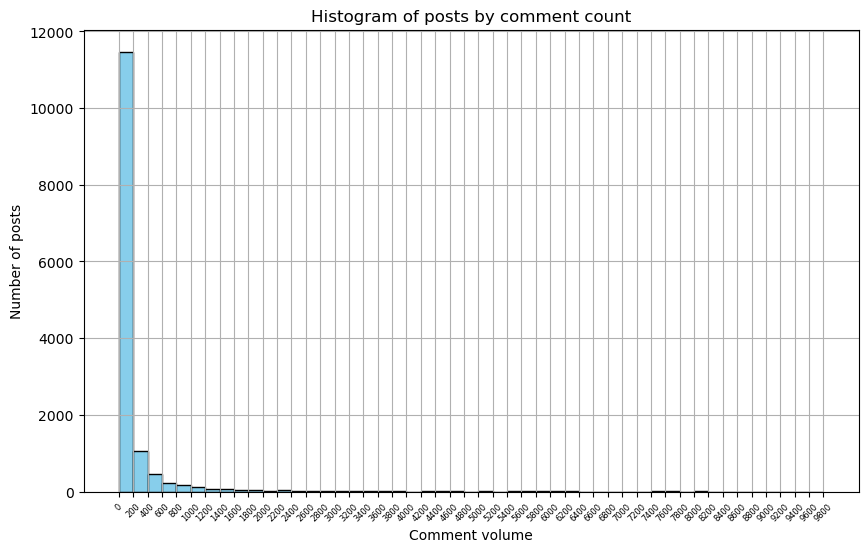

In [17]:
# Defining the bins for comment volume
# Keeping the range as 200 since it's getting cluttered
bins = np.arange(0, posts_with_comments_only['comments'].max() + 1, 200)

# Plotting the histogram of posts based on comment volume
plt.figure(figsize=(10, 6))
plt.hist(posts_with_comments_only['comments'], bins=bins, color='skyblue', edgecolor='black')
plt.title('Histogram of posts by comment count')
plt.xlabel('Comment volume')
plt.ylabel('Number of posts')
plt.xticks(bins)
# Adjusting the font size of x-axis labels and rotating for better view
plt.xticks(bins, fontsize=6, rotation=45)  
plt.grid(True)
plt.grid(True)
plt.show()


In [18]:
# Calculating percentiles
percentiles_commvolume = [25, 50, 75, 90, 95, 99]
percentile_values = np.percentile(posts_with_comments_only['comments'], percentiles_commvolume)

# Creating a DataFrame to display the results
summary_df_post_comment_volume = pd.DataFrame({
    'Percentile': percentiles_commvolume,
    'Percentile Value': percentile_values
})

# Displaying the tabular summary
print(summary_df_post_comment_volume)


   Percentile  Percentile Value
0          25              6.00
1          50             26.00
2          75            114.00
3          90            391.00
4          95            761.00
5          99           2111.32


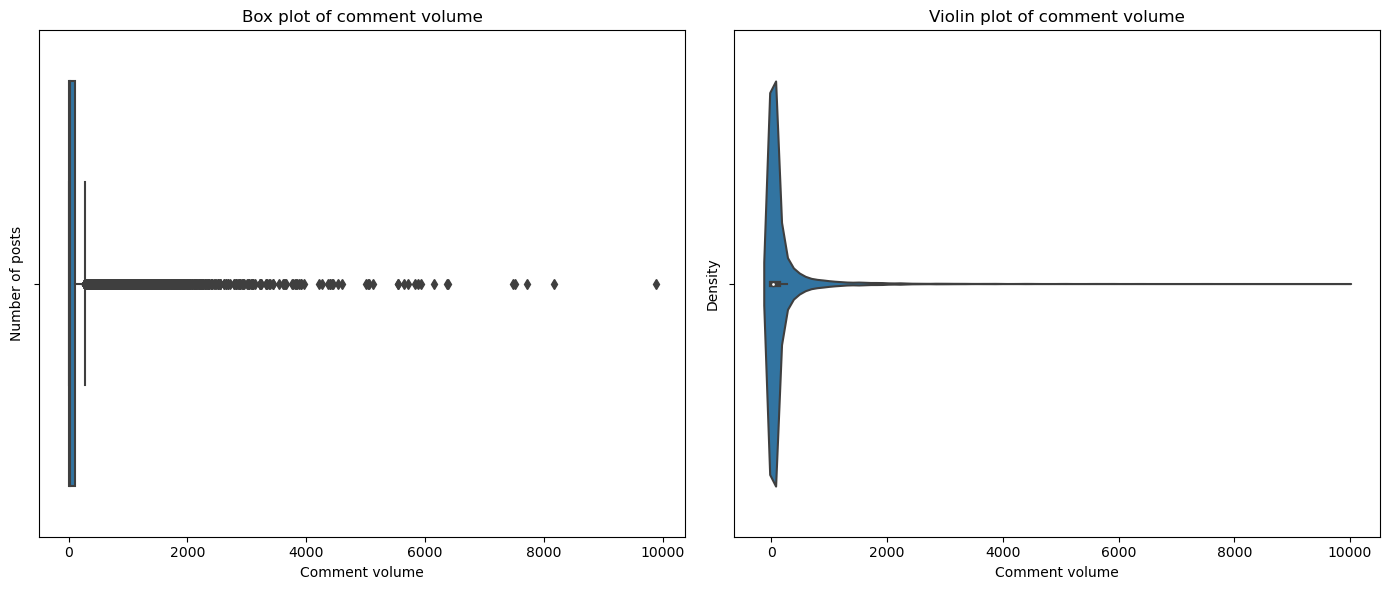

In [19]:
# Creating a figure with two subplots - box plot and violin plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Box plot
sns.boxplot(data=posts_with_comments_only, x='comments', ax=axes[0])
axes[0].set_title('Box plot of comment volume')
axes[0].set_xlabel('Comment volume')
axes[0].set_ylabel('Number of posts')

# Violin plot
sns.violinplot(data=posts_with_comments_only, x='comments', ax=axes[1])
axes[1].set_title('Violin plot of comment volume')
axes[1].set_xlabel('Comment volume')
axes[1].set_ylabel('Density')

# Adjusting layout to prevent overlap
plt.tight_layout()

# Displaying the plots
plt.show()

### Analysis of posts - by tags and overall

C:\Users\veena\AppData\Local\Temp\ipykernel_54088\3241557683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts_with_comments_only['tag'].fillna('No tag', inplace=True)


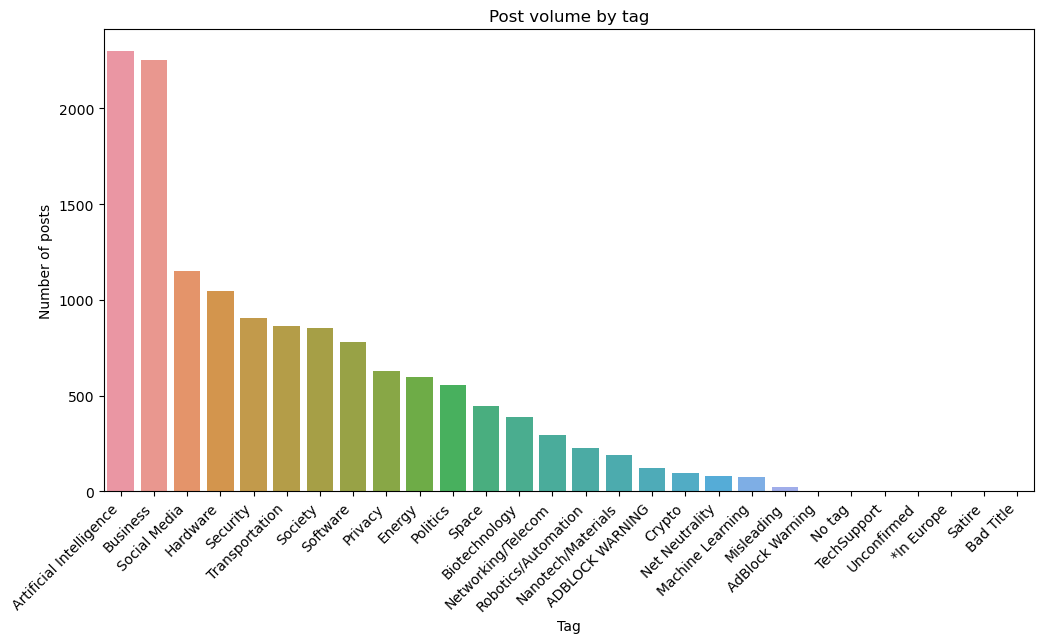

In [20]:
# Fill missing values in tag column with 'No tag'
posts_with_comments_only['tag'].fillna('No tag', inplace=True)

# Visualizing the count of posts by tag
plt.figure(figsize=(12, 6))
sns.countplot(data=posts_with_comments_only, x='tag', order=posts_with_comments_only['tag'].value_counts().index)
plt.title('Post volume by tag')
plt.xlabel('Tag')
plt.ylabel('Number of posts')
plt.xticks(rotation=45, ha='right')
plt.show()


<Figure size 1200x600 with 0 Axes>

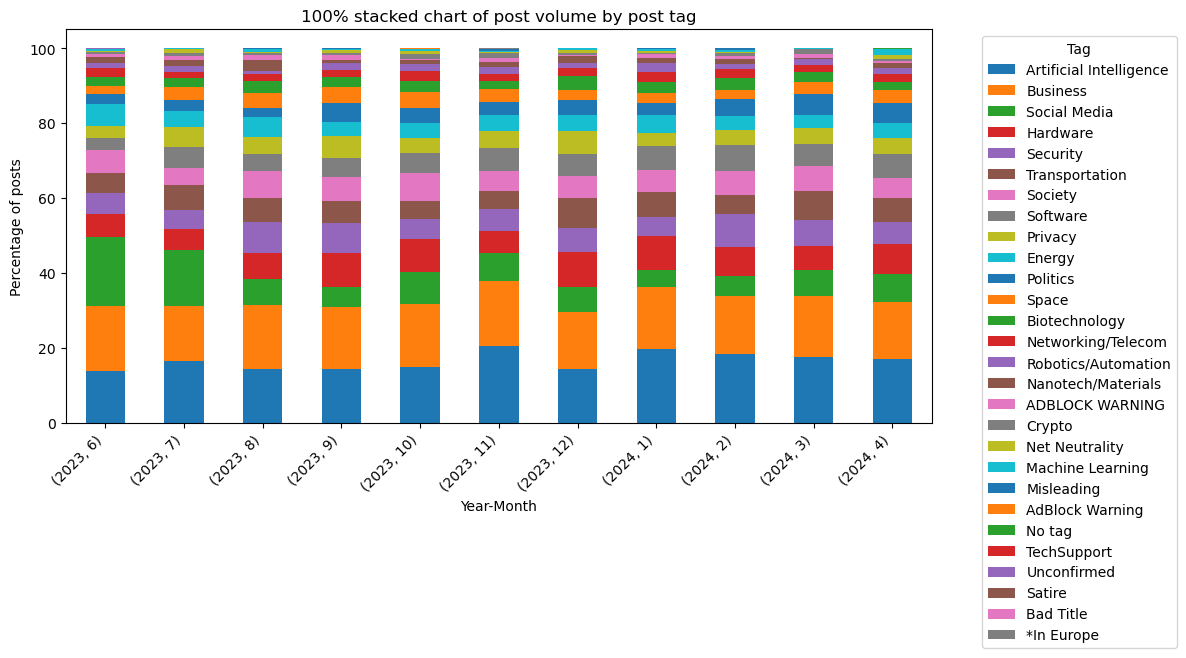

In [21]:
# Creating a pivot table to aggregate post volume by year, month, and tag
pivot_table_tag = posts_with_comments_only.pivot_table(index=['year', 'month'], columns='tag', 
                                                       values='post_id', aggfunc='count', fill_value=0)

# Calculating the percentage of post volume for each tag within each month
pivot_table_tag_percentage = pivot_table_tag.div(pivot_table_tag.sum(axis=1), axis=0) * 100

# Sorting the columns of the pivot table 
pivot_table_tag_percentage_sorted = pivot_table_tag_percentage[pivot_table_tag_percentage.sum().
                                                               sort_values(ascending=False).index]


# Plotting 100% stacked bar chart
plt.figure(figsize=(12, 6))
pivot_table_tag_percentage_sorted.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('100% stacked chart of post volume by post tag')
plt.xlabel('Year-Month')
plt.ylabel('Percentage of posts')
plt.legend(title='Tag', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### There is trend of AI being top post title overtime.

In [22]:
# Converting the pivot table to a tabular summary
summary_df_tag_share = pivot_table_tag_percentage_sorted.reset_index()

summary_df_tag_share

tag  year  month  Artificial Intelligence   Business  Social Media  Hardware  \
0    2023      6                13.706041  17.403066     18.394950  6.131650   
1    2023      7                16.512992  14.752724     14.836547  5.532272   
2    2023      8                14.273649  17.145270      7.010135  7.010135   
3    2023      9                14.226974  16.611842      5.263158  9.292763   
4    2023     10                14.980392  16.705882      8.627451  8.784314   
5    2023     11                20.462046  17.491749      7.260726  5.858086   
6    2023     12                14.285714  15.334948      6.698951  9.200969   
7    2024      1                19.754098  16.475410      4.672131  8.934426   
8    2024      2                18.334500  15.395381      5.458362  7.837649   
9    2024      3                17.560322  16.219839      7.104558  6.166220   
10   2024      4                16.917293  15.187970      7.593985  7.894737   

tag  Security  Transportation   Society  Software  ...  Net Neutrality  \
0    5.770965        5.320108  6.221821  3.155996  ...        0.270514   
1    5.113160        6.621961  4.694049  5.448449  ...        1.005868   
2    8.023649        6.503378  7.263514  4.645270  ...        0.253378   
3    7.812500        6.003289  6.332237  5.180921  ...        0.904605   
4    5.254902        4.862745  7.450980  5.254902  ...        0.784314   
5    5.940594        4.867987  5.445545  6.023102  ...        0.412541   
6    6.537530        7.909605  5.811138  6.053269  ...        0.887813   
7    5.000000        6.885246  5.737705  6.311475  ...        0.327869   
8    8.677397        5.108467  6.438069  6.927922  ...        0.349895   
9    7.104558        7.707775  6.568365  5.898123  ...        0.067024   
10   5.864662        6.466165  5.413534  6.390977  ...        1.278195   

tag  Machine Learning  Misleading  AdBlock Warning    No tag  TechSupport  \
0            0.450857    0.000000         0.000000  0.000000     0.090171   
1            0.335289    0.000000         0.000000  0.000000     0.000000   
2            0.844595    0.253378         0.000000  0.000000     0.000000   
3            0.328947    0.164474         0.000000  0.000000     0.000000   
4            0.549020    0.235294         0.078431  0.000000     0.000000   
5            0.330033    0.330033         0.000000  0.082508     0.000000   
6            0.484262    0.000000         0.000000  0.000000     0.000000   
7            0.655738    0.163934         0.000000  0.000000     0.000000   
8            0.489853    0.419874         0.000000  0.000000     0.000000   
9            0.201072    0.000000         0.000000  0.000000     0.000000   
10           1.428571    0.075188         0.150376  0.075188     0.000000   

tag  Unconfirmed    Satire  Bad Title  *In Europe  
0       0.090171  0.000000   0.000000    0.000000  
1       0.000000  0.000000   0.000000    0.000000  
2       0.000000  0.000000   0.000000    0.000000  
3       0.000000  0.000000   0.000000    0.000000  
4       0.000000  0.000000   0.000000    0.000000  
5       0.000000  0.082508   0.082508    0.082508  
6       0.000000  0.000000   0.000000    0.000000  
7       0.000000  0.000000   0.000000    0.000000  
8       0.000000  0.000000   0.000000    0.000000  
9       0.000000  0.000000   0.000000    0.000000  
10      0.000000  0.000000   0.000000    0.000000  

[11 rows x 30 columns]

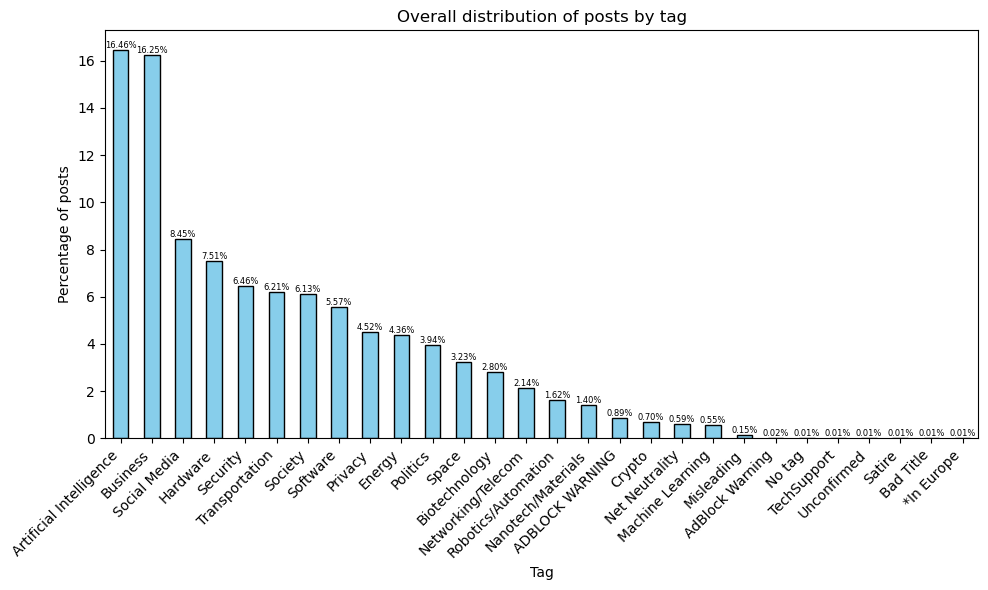

Cumulative percentage of posts by tag:
tag
Artificial Intelligence     16.455820
Business                    32.703464
Social Media                41.150823
Hardware                    48.663843
Security                    55.127472
Transportation              61.332629
Society                     67.457807
Software                    73.029662
Privacy                     77.545957
Energy                      81.906386
Politics                    85.848713
Space                       89.080088
Biotechnology               91.878402
Networking/Telecom          94.014863
Robotics/Automation         95.638213
Nanotech/Materials          97.037587
ADBLOCK WARNING             97.924792
Crypto                      98.627564
Net Neutrality              99.222292
Machine Learning            99.776678
Misleading                  99.925966
AdBlock Warning             99.946767
No tag                      99.961103
TechSupport                 99.969300
Unconfirmed                 99.977498
Satire 

In [23]:
# Calculating the percentage of post volume for each tag across all months and years
overall_percentage_tag = pivot_table_tag_percentage_sorted.mean()

# Plotting the 100% stacked bar chart with percentage values
plt.figure(figsize=(10, 6))
ax = overall_percentage_tag.plot(kind='bar', color='skyblue', edgecolor='black')
for idx, value in enumerate(overall_percentage_tag):
    ax.annotate(f'{value:.2f}%', (idx, value), ha='center', va='bottom', fontsize = 6)

plt.title('Overall distribution of posts by tag')
plt.xlabel('Tag')
plt.ylabel('Percentage of posts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Cumulative percentage to identify the pareto
overall_cumulative_percentage_tag = overall_percentage_tag.cumsum()
print("Cumulative percentage of posts by tag:")
print(overall_cumulative_percentage_tag)


#### The top 10 tags account for ~82% of the post volume - this is a pareto like effect

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Cosine similarity between 2 input texts: this may be computationally expensive
# Cosine similarity between title and text is calculated using TF-IDF
def cosine_similarity(title, text):
    vectorizer = TfidfVectorizer()
    tf_idf_matrix = vectorizer.fit_transform([title, text])
    return (tf_idf_matrix * tf_idf_matrix.T).toarray()[0][1]

posts_with_comments_only['title_text_similarity'] = posts_with_comments_only[['title', 'text']].apply(lambda x: 
                                                                                                            cosine_similarity(x['title'], 
                                                                                                                              x['text']), 
                                                                                                            axis=1)

C:\Users\veena\AppData\Local\Temp\ipykernel_54088\3981990063.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts_with_comments_only['title_text_similarity'] = posts_with_comments_only[['title', 'text']].apply(lambda x:


In [25]:
# Calculating descriptive statistics
similarity_stats = posts_with_comments_only['title_text_similarity'].describe()
print(similarity_stats)

count    13899.000000
mean         0.998942
std          0.026732
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: title_text_similarity, dtype: float64


#### Title and text are basically the same for posts

#### Plotting n-grams of title text - posts

In [26]:
# Function to plot top n features
def plot_top_features(feature_names, feature_counts, title):
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, feature_counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Feature')
    plt.title(title)
    plt.gca().invert_yaxis()  # to show in descending order
    plt.show()

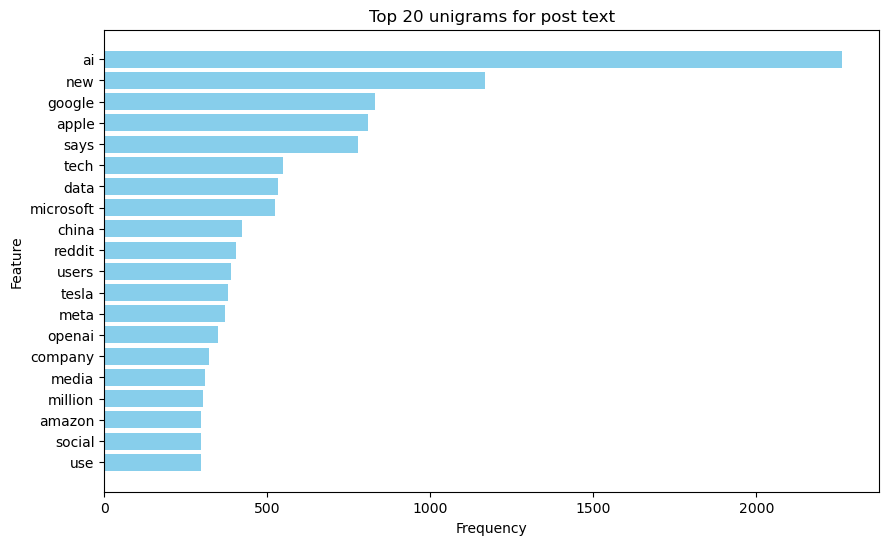

In [27]:
# Initializing CountVectorizer for unigrams
unigram_vectorizer = CountVectorizer(stop_words='english')

# Fitting and transform the 'text' column to extract unigrams
unigram_matrix = unigram_vectorizer.fit_transform(posts_with_comments_only['text'])

# Getting feature names (unigrams)
unigram_feature_names = unigram_vectorizer.get_feature_names_out()


# Plotting top 20 unigrams
top_unigrams = sorted(zip(unigram_feature_names, unigram_matrix.sum(axis=0).tolist()[0]), 
                      key=lambda x: x[1], reverse=True)[:20]
unigram_names, unigram_counts = zip(*top_unigrams)
plot_top_features(unigram_names, unigram_counts, 'Top 20 unigrams for post text')

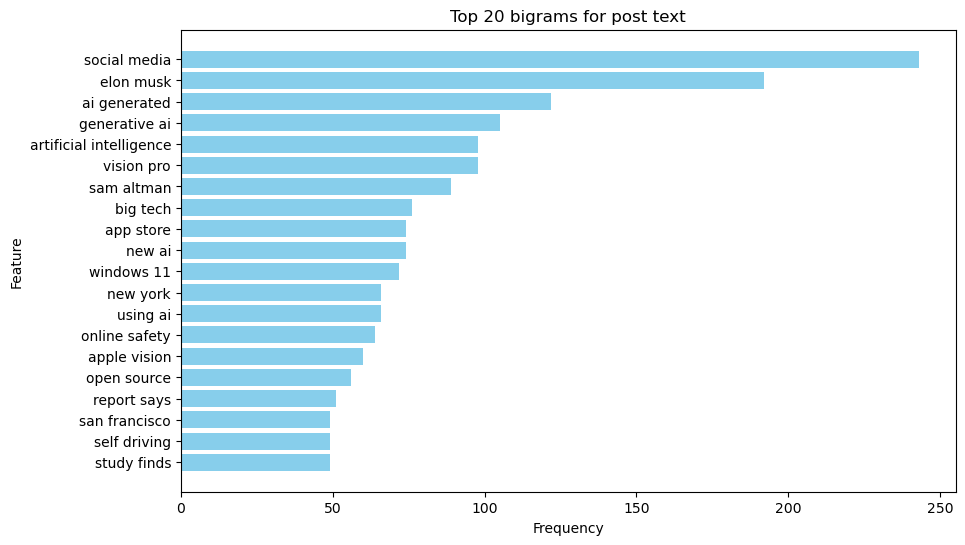

In [28]:
# Initializing CountVectorizer for bigrams
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')

# Fitting and transform the 'text' column to extract bigrams
bigram_matrix = bigram_vectorizer.fit_transform(posts_with_comments_only['text'])

# Getting feature names (bigrams)
bigram_feature_names = bigram_vectorizer.get_feature_names_out()

# Plotting top 20 bigrams
top_bigrams = sorted(zip(bigram_feature_names, bigram_matrix.sum(axis=0).tolist()[0]), 
                     key=lambda x: x[1], reverse=True)[:20]
bigram_names, bigram_counts = zip(*top_bigrams)
plot_top_features(bigram_names, bigram_counts, 'Top 20 bigrams for post text')

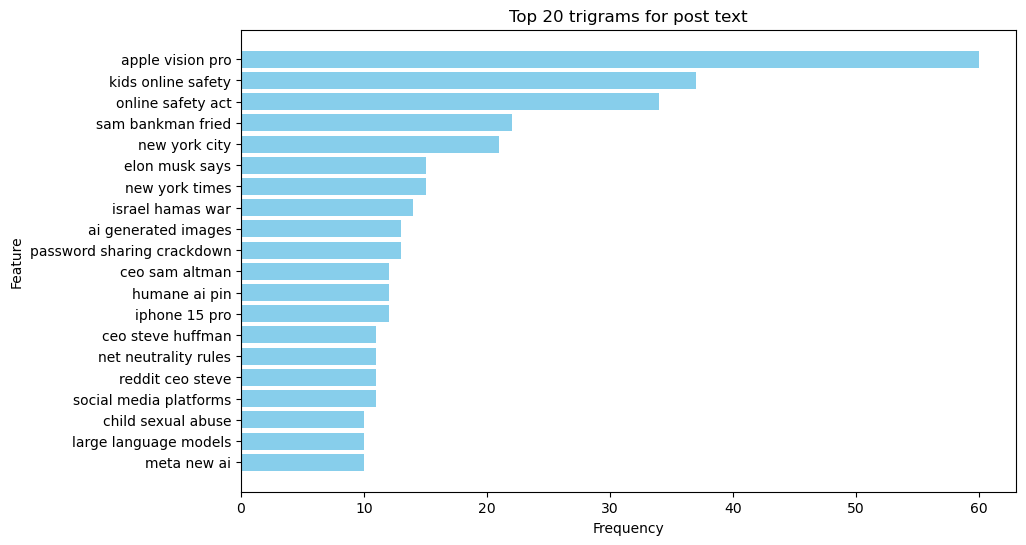

In [29]:
# Initializing CountVectorizer for trigrams
trigram_vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words='english')

# Fitting and transform the 'text' column to extract trigrams
trigram_matrix = trigram_vectorizer.fit_transform(posts_with_comments_only['text'])

# Getting feature names (trigrams)
trigram_feature_names = trigram_vectorizer.get_feature_names_out()

# Plotting top 20 trigrams
top_trigrams = sorted(zip(trigram_feature_names, trigram_matrix.sum(axis=0).tolist()[0]), 
                      key=lambda x: x[1], reverse=True)[:20]
trigram_names, trigram_counts = zip(*top_trigrams)
plot_top_features(trigram_names, trigram_counts, 'Top 20 trigrams for post text')

#### Sentiment analysis - posts

In [30]:
posts_with_comments_only.columns

Index(['post_id', 'comment_id', 'author', 'datetime', 'title', 'url', 'score',
       'comments', 'text', 'author_post_karma', 'tag', 'date',
       'has_comments_flag', 'year', 'month', 'title_text_similarity'],
      dtype='object')

In [31]:
from textblob import TextBlob

# Function to classify sentiment using TextBlob
def get_sentiment(text):
    analysis = TextBlob(text)
    # Classifying sentiment as positive, negative, or neutral based on polarity score
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Applying the function to classify sentiment for each post text
posts_with_comments_only['sentiment'] = posts_with_comments_only['text'].apply(get_sentiment)

C:\Users\veena\AppData\Local\Temp\ipykernel_54088\1294541486.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts_with_comments_only['sentiment'] = posts_with_comments_only['text'].apply(get_sentiment)


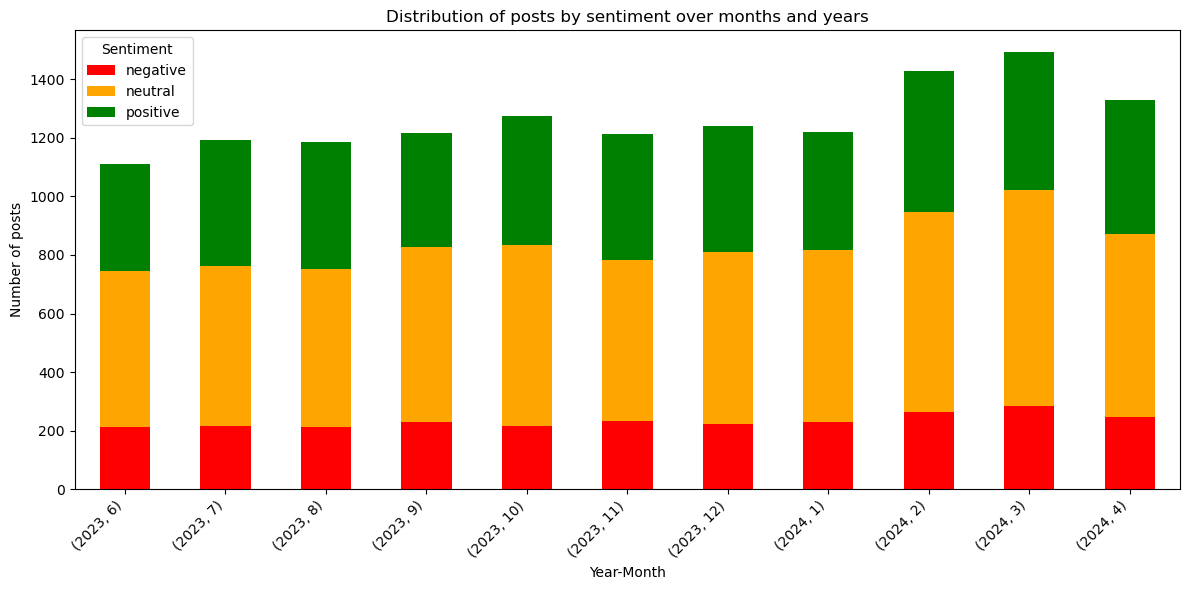

In [38]:
# Grouping data by year_month and sentiment to calculate counts
sentiment_counts_posts_mthyr = posts_with_comments_only.groupby(['year', 'month', 'sentiment']).size().unstack(fill_value=0)

# Defining custom colors for each sentiment
senti_colors_posts = {'negative': 'red', 'neutral': 'orange', 'positive': 'green'}

# Reordering the sentiments to match the order of the stacked bar chart
post_sentiments_ordered = sentiment_counts_posts_mthyr.columns

# Create a list of colors in the same order as the sentiments
colors_ordered_posts = [senti_colors_posts[sentiment] for sentiment in post_sentiments_ordered]

# Plotting stacked bar chart with custom colors
sentiment_counts_posts_mthyr.plot(kind='bar', stacked=True, figsize=(12, 6), color=senti_colors_posts.values())
plt.title('Distribution of posts by sentiment over months and years')
plt.xlabel('Year-Month')
plt.ylabel('Number of posts')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Sentiment', labels=senti_colors_posts.keys())
plt.tight_layout()
plt.show()
# Need to make the ordering dynamic

In [41]:
colors_ordered_posts

['red', 'orange', 'green']

In [42]:
# Grouping data by year, month, and sentiment and counting rows
post_volume_over_time_sentiment = posts_with_comments_only.groupby(['year', 'month', 'sentiment']).size().unstack(fill_value=0)

# Resetting index to make year and month columns accessible
post_volume_over_time_sentiment = post_volume_over_time_sentiment.reset_index()

# Displaying the tabular summary
print("Tabular summary of post volume by sentiment over time:\n")
print(post_volume_over_time_sentiment)

Tabular summary of post volume by sentiment over time:

sentiment  year  month  negative  neutral  positive
0          2023      6       211      534       364
1          2023      7       215      548       430
2          2023      8       211      540       433
3          2023      9       228      599       389
4          2023     10       215      618       442
5          2023     11       234      548       430
6          2023     12       224      586       429
7          2024      1       229      588       403
8          2024      2       263      685       481
9          2024      3       285      737       470
10         2024      4       248      623       459


#### Majority of the post titles have neutral sentiment

In [ ]:
### Placeholder for sentiment wordclouds, possibly for select tags

### Text cleaning and pre-processing - posts

In [43]:
# Text cleaning function

import re
import string
import contractions
from nltk.corpus import stopwords

# Remove URLs and HTML tags
def remove_urls_html_tags(text):
    pattern = r"https?://\S+|www\.\S+|<.*?>"
    return re.sub(pattern, "", text, flags=re.MULTILINE)

# Expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Remove unwanted characters, numbers, punctuations
def remove_non_ascii_and_emojis(text):
    emoji_pattern = re.compile(
        r'['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', re.sub(r'[^\x00-\x7F]+', r'', text))


# Custom stopwords (add to list here as required)
# Remove stopwords
def remove_stopwords(text):
    #custom_stopwords = ["reddit"]
    stop_words = stopwords.words("english") 
    return " ".join([word for word in text.split() if word not in stop_words])

def clean_text_function_reddit(text):
    # Remove lowercase and remove double spaces
    text = text.lower()
    text = text.replace("  ", " ")  
    text = remove_urls_html_tags(text)
    text = remove_non_ascii_and_emojis(text)
    text = expand_contractions(text)
    text = remove_stopwords(text)
    return text


In [115]:
# Applying the cleaning function to the title column
posts_with_comments_only['title_clean'] = posts_with_comments_only['title'].apply(clean_text_function_reddit)

C:\Users\veena\AppData\Local\Temp\ipykernel_54088\2293472945.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\veena\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:6827: RuntimeWarning:

invalid value encountered in multiply



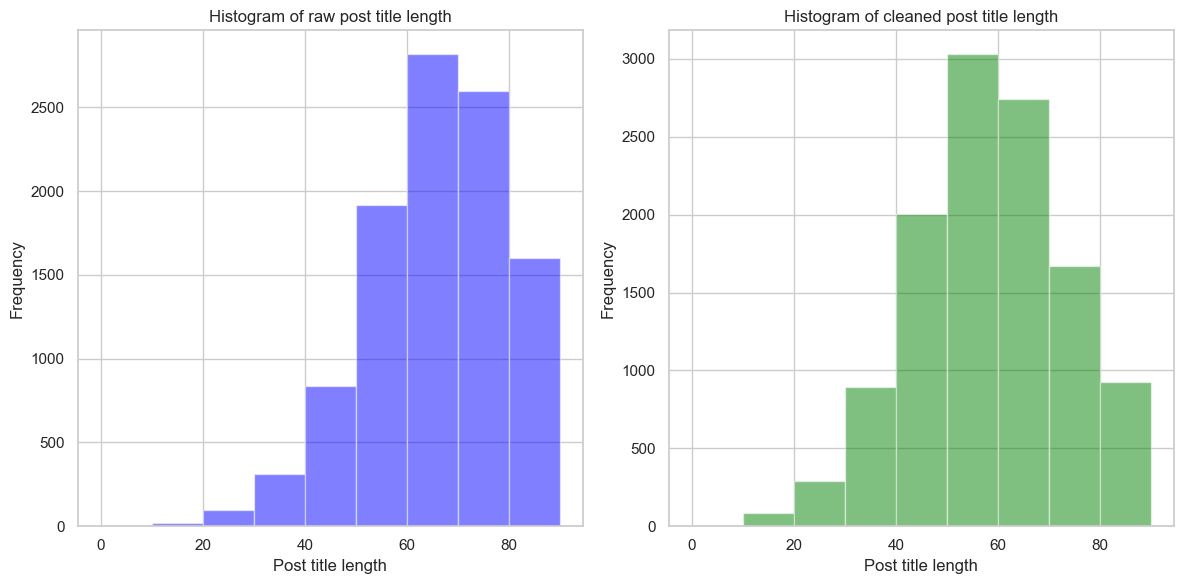

In [116]:
import matplotlib.pyplot as plt
import numpy as np

# Calculating the length of the title in the raw and cleaned title columns
posts_raw_text_lengths = posts_with_comments_only['title'].apply(len)
posts_cleaned_text_lengths = posts_with_comments_only['title_clean'].apply(len)

# Defining custom bins
# Bins from 0 to 100 with step size 20
custom_bins_posts = np.arange(0, 100, 10)  
# Appending infinity to include values above 100
custom_bins_posts = np.append(custom_bins_posts, np.inf)  

# Defining subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plotting histogram for raw title lengths
axes[0].hist(posts_raw_text_lengths, bins=custom_bins_posts, alpha=0.5, color='blue', edgecolor='White')
axes[0].set_title('Histogram of raw post title length')
axes[0].set_xlabel('Post title length')
axes[0].set_ylabel('Frequency')
# Adding grid lines
axes[0].grid(True) 
# Making the subplot background opaque
axes[0].set_facecolor('white')  

# Plotting histogram for cleaned title lengths
axes[1].hist(posts_cleaned_text_lengths, bins=custom_bins_posts, alpha=0.5, color='green', edgecolor='White')
axes[1].set_title('Histogram of cleaned post title length')
axes[1].set_xlabel('Post title length')
axes[1].set_ylabel('Frequency')
# Adding grid lines
axes[1].grid(True) 
 # Making the subplot background opaque
axes[1].set_facecolor('white') 

plt.tight_layout()
plt.show()

C:\Users\veena\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:6827: RuntimeWarning:

invalid value encountered in multiply



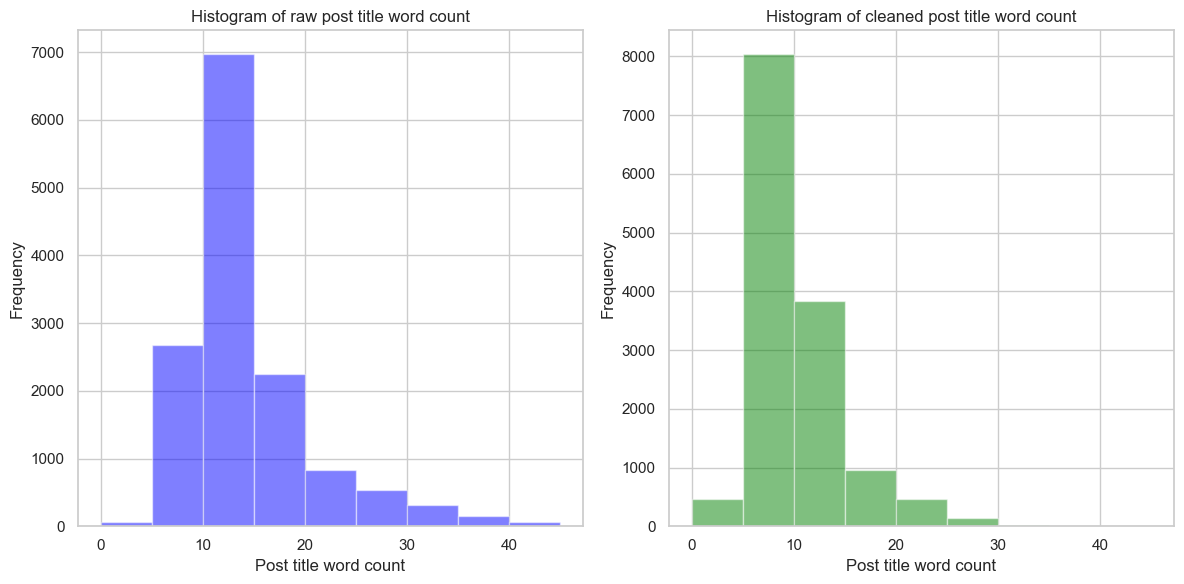

In [120]:
# Calculating the word count of the title in the raw and cleaned title columns
posts_raw_text_words = posts_with_comments_only['text'].str.split().apply(len)
posts_cleaned_text_words = posts_with_comments_only['title_clean'].str.split().apply(len)

# Defining custom bins
# Bins from 0 to 50 with step size 5
custom_bins_clean_post_len = np.arange(0, 50, 5)  
# Appending infinity to include values above 100
custom_bins_clean_post_len = np.append(custom_bins_clean_post_len, np.inf)  

# Creating subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plotting histogram for raw title word counts
axes[0].hist(posts_raw_text_words, bins=custom_bins_clean_post_len, alpha=0.5, color='blue',edgecolor='White')
axes[0].set_title('Histogram of raw post title word count')
axes[0].set_xlabel('Post title word count')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)  # Adding grid lines
axes[0].set_facecolor('white')  # Making the subplot background opaque

# Plotting histogram for cleaned title word counts
axes[1].hist(posts_cleaned_text_words, bins=custom_bins_clean_post_len, alpha=0.5, color='green',edgecolor='White')
axes[1].set_title('Histogram of cleaned post title word count')
axes[1].set_xlabel('Post title word count')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)  # Adding grid lines
axes[1].set_facecolor('white')  # Making the subplot background opaque

plt.tight_layout()
plt.show()


#### Not much difference in character and word count between raw and cleaned post titles - this is expected since post titles are largely clean

In [49]:
# Creating a separate df with AI tag since it's the largest tag by post volume
posts_with_comments_only_ai_tag = posts_with_comments_only[posts_with_comments_only['tag'] == 'Artificial Intelligence']

### kmeans for clustering 

In [50]:
# Initializing TfidfVectorizer to convert text data into TF-IDF features
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features = 1000)
tfidf_vectorizer_ai = TfidfVectorizer(stop_words='english', max_features = 1000)

# Fitting and transform the text data to TF-IDF features
tfidf_matrix_post_text = tfidf_vectorizer.fit_transform(posts_with_comments_only['title_clean'])
tfidf_matrix_post_text_ai = tfidf_vectorizer_ai.fit_transform(posts_with_comments_only_ai_tag['title_clean'])

In [51]:
tfidf_matrix_post_text_ai

<2297x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 13422 stored elements in Compressed Sparse Row format>

In [52]:
# Function to define Hopkin's test of clustering tendency
def hopkins(X, n):
    d = X.shape[1]
    # Creating random data points
    random_data = np.random.rand(n, d)
    # Computing nearest neighbors for both actual and random data
    knn_actual = NearestNeighbors(n_neighbors=1).fit(X)
    knn_random = NearestNeighbors(n_neighbors=1).fit(random_data)
    # Computing distances and sum them
    actual_distances = knn_actual.kneighbors(X)[0]
    random_distances = knn_random.kneighbors(random_data)[0]
    w = sum(actual_distances) / (sum(actual_distances) + sum(random_distances))
    return w

In [54]:
# Running Hopkins test to check if there are clusters in the data
# A value closer to 1 suggests a higher tendency for clustering
# This is a computationally expensive test
hopkins_statistic = hopkins(tfidf_matrix_post_text.toarray(), tfidf_matrix_post_text.shape[0])
print("Hopkins Statistic:", hopkins_statistic)
# Hopkin's statistic is too low indicating low clusterability

Hopkins Statistic: [0.01711079]


In [55]:
# This is for the AI tagged posts only
# Running Hopkins test to check if there are clusters in the data
# A value closer to 1 suggests a higher tendency for clustering
# This is a computationally expensive test
hopkins_statistic_ai = hopkins(tfidf_matrix_post_text_ai.toarray(), tfidf_matrix_post_text_ai.shape[0])
print("Hopkins Statistic for AI tagged posts:", hopkins_statistic_ai)
# Hopkin's statistic is still low but better than overall

Hopkins Statistic for AI tagged posts: [0.01941477]


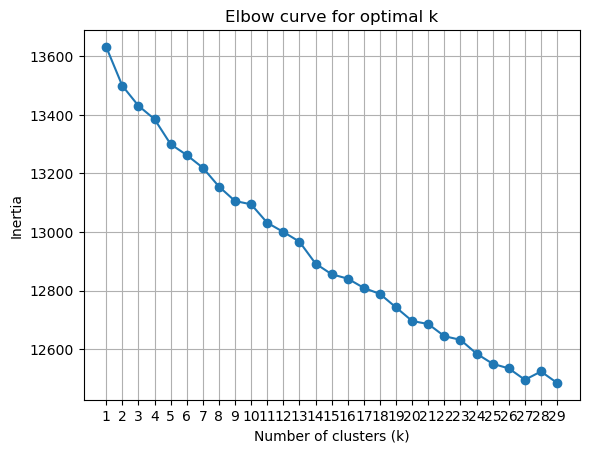

In [56]:
# Plotting the elbow chart to find the optimal k value
# Inertia is the same as SSE (Sum of Squared Errors) 
# Iterating k from from 1-30
inertia = []
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, random_state=123, n_init=10)
    kmeans.fit(tfidf_matrix_post_text)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 30), inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow curve for optimal k')
plt.xticks(range(1, 30))
plt.grid(True)
plt.show()

# There is no clear elbow point

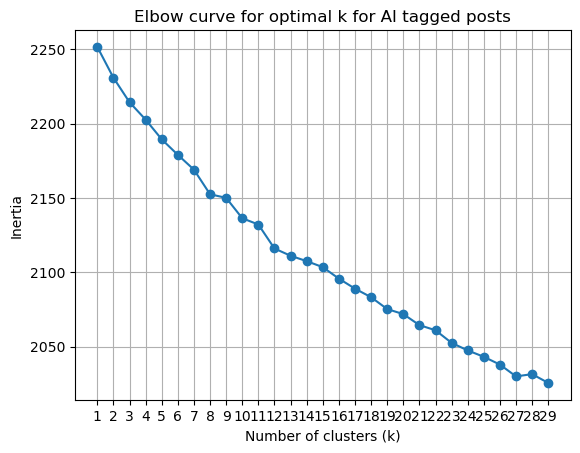

In [57]:
# Plotting the elbow chart to find the optimal k value
# Inertia is the same as SSE (Sum of Squared Errors) 
# Iterating k from from 1-30
inertia = []
for k in range(1, 30):
    kmeans_ai = KMeans(n_clusters=k, random_state=123, n_init=10)
    kmeans_ai.fit(tfidf_matrix_post_text_ai)
    inertia.append(kmeans_ai.inertia_)

plt.plot(range(1, 30), inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow curve for optimal k for AI tagged posts')
plt.xticks(range(1, 30))
plt.grid(True)
plt.show()

# There is no clear elbow point

### Topic modeling using Latent Dirichlet allocation

In [58]:
# Tokenization and vectorization for overall data
preprocessed_post_text = posts_with_comments_only['title_clean']
# Tokenization and vectorization for AI tag
preprocessed_post_text_ai = posts_with_comments_only_ai_tag['title_clean']

# Vectorizer instance initialization with unigrams for overall data
vectorizer_for_lda = CountVectorizer(stop_words='english', max_features=1000)

# Vectorizer instance initialization with trigrams for AI tagged data
vectorizer_for_lda_ai = CountVectorizer(ngram_range=(3, 3), stop_words='english', max_features=1000)

# Creating the unigrams trigrams for overall data
X_post_lda = vectorizer_for_lda.fit_transform(preprocessed_post_text)
# Creating the trigrams trigrams for AI tag
X_post_lda_ai = vectorizer_for_lda_ai.fit_transform(preprocessed_post_text_ai)

In [108]:
# Training the LDA model for overall data
num_topics = 10
# Training the LDA model for AI tagged data
num_topics_ai = 5

# Running the LDA model for overall data
lda_model_post = LatentDirichletAllocation(n_components=num_topics, random_state=123)
# Running the LDA model for AI tagged data
lda_model_post_ai = LatentDirichletAllocation(n_components=num_topics_ai, random_state=123)

# Creating topic on the overall data
lda_model_post.fit(X_post_lda)
# Creating topic on the AI tagged data
lda_model_post_ai.fit(X_post_lda_ai)

# Extracting topic-term distribution matrix from the LDA model
topic_term_dists = lda_model_post.components_
# Extracting topic-term distribution matrix from the LDA model for AI tag
topic_term_dists_ai = lda_model_post_ai.components_

In [60]:
# Interpreting the topics for overall data
feature_names_post_text = vectorizer_for_lda.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model_post.components_):
    print(f"Topic {topic_idx}:")
    top_words_idx = topic.argsort()[:-10:-1]  # Getting indices of top 10 words for each topic
    top_words = [feature_names_post_text[i] for i in top_words_idx]
    print(top_words)

Topic 0:
['windows', 'microsoft', 'ai', 'electric', 'cars', 'tech', 'big', 'self', '11']
Topic 1:
['apple', 'iphone', 'app', 'court', 'youtube', 'store', 'india', 'battery', 'ev']
Topic 2:
['ai', 'says', 'openai', 'reddit', 'ceo', 'musk', 'elon', 'people', 'google']
Topic 3:
['researchers', 'lawsuit', 'end', 'free', 'new', 'shows', 'service', 'games', 'google']
Topic 4:
['new', 'solar', 'power', 'energy', 'open', 'technology', 'source', 'quantum', 'eu']
Topic 5:
['tesla', 'china', 'million', 'year', '000', 'data', 'says', 'chip', 'chinese']
Topic 6:
['tiktok', 'tech', 'workers', 'amazon', 'ban', 'industry', 'says', 'office', 'employees']
Topic 7:
['google', 'users', 'data', 'search', 'privacy', 'news', 'reddit', 'surveillance', 'uk']
Topic 8:
['ai', 'online', 'safety', 'space', 'intelligence', 'artificial', 'kids', 'disinformation', 'act']
Topic 9:
['ai', 'media', 'social', 'meta', 'pro', 'facebook', 'new', 'content', 'vision']


In [109]:
# Interpreting the topic for AI tagged data
feature_names_post_text_ai = vectorizer_for_lda_ai.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model_post_ai.components_):
    print(f"Topic {topic_idx}:")
    top_words_idx = topic.argsort()[:-15:-1]  # Getting indices of top 15 words for each topic
    top_words_ai = [feature_names_post_text_ai[i] for i in top_words_idx]
    print(top_words_ai)

Topic 0:
['ai generated images', 'ai generated content', 'metas new ai', 'sue openai copyright', 'openai copyright infringement', 'grisham george martin', 'john grisham george', 'new ai assistant', 'stability ai ceo', 'humanes ai pin', 'ai generated articles', 'return openai ceo', 'crash decade sec', 'sec head says']
Topic 1:
['large language models', 'ceo sam altman', 'ai image generator', 'child sex abuse', 'sex abuse images', 'artificial intelligence ai', 'elon musk says', 'openai ceo sam', 'ai powered search', 'child sexual abuse', 'microsoft hires openai', 'generative artificial intelligence', 'artificial intelligence technology', 'ai generated books']
Topic 2:
['train ai models', 'admits gemini ai', 'gemini ai demo', 'google admits gemini', 'mind reading ai', 'generative ai features', 'artists fight ai', 'microsoft copilot ai', 'ai generated videos', 'google says ai', 'artificial general intelligence', 'ai year according', 'year according recent', 'according recent poll']
Topic 3

We're getting explainable results for LDA of posts tagged as AI with 5 topics

1) Topic 0: News around training data for AI models (since there are references to authors and copyright)
2) Topic 1: Danger of AI, focused on deepfakes (since there are references to LLMs, sexual abuse)
3) Topic 2: News about AI tools, dominated by Google’s Gemini launch
4) Topic 3: Mixed topic about announcements and AI tool announcements
5) Topic 4: New AI prdouct launches like Humane AI pin and controversies around AI tool usage by students

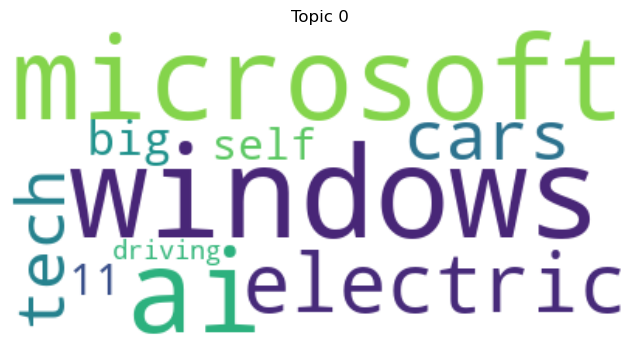

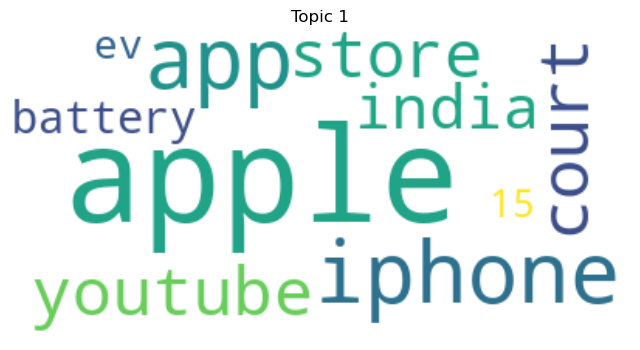

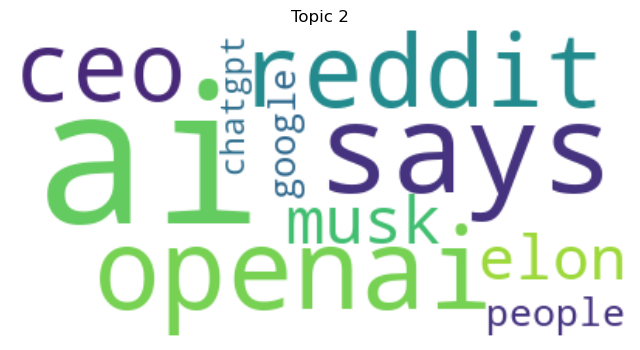

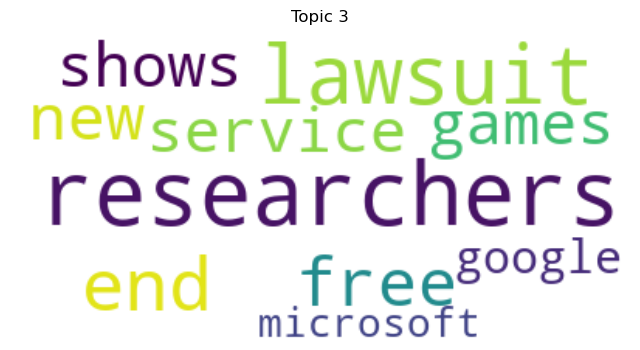

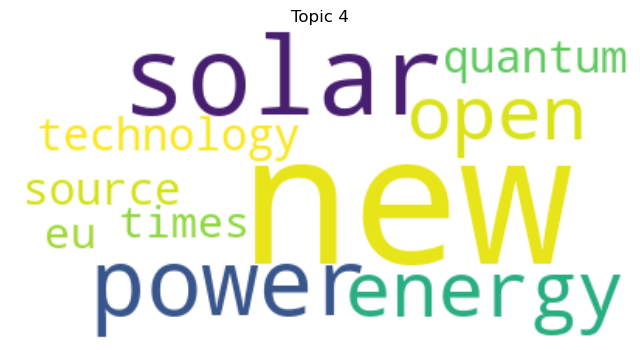

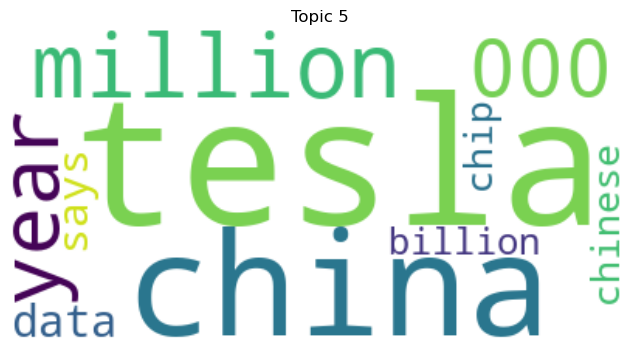

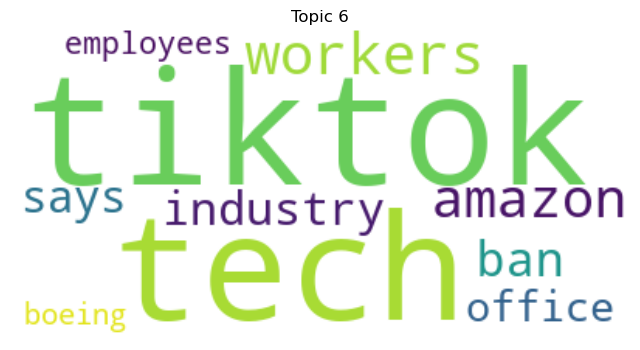

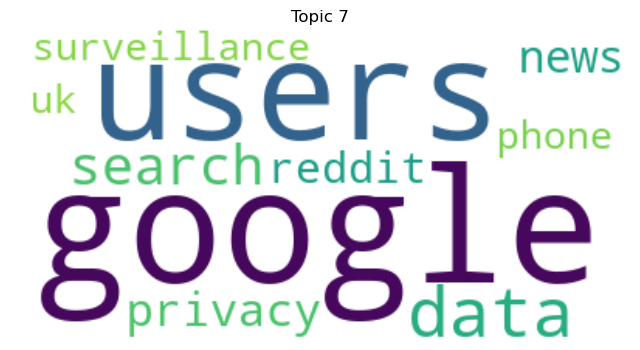

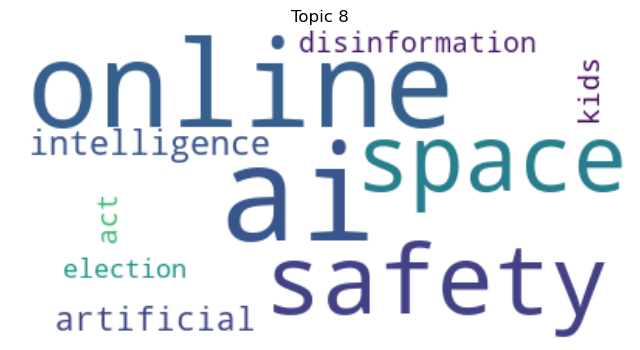

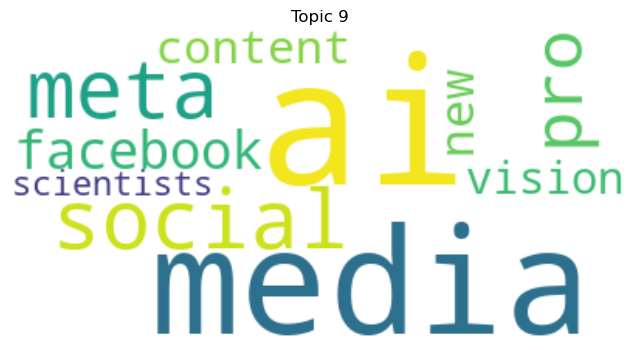

In [62]:
# Visualizing word clouds for each topic
for topic_idx, topic in enumerate(lda_model_post.components_):
    word_freq = {vectorizer_for_lda.get_feature_names_out()[i]: topic[i] for i in topic.argsort()[:-11:-1]}
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Topic {topic_idx}")
    plt.axis('off')
    plt.show()

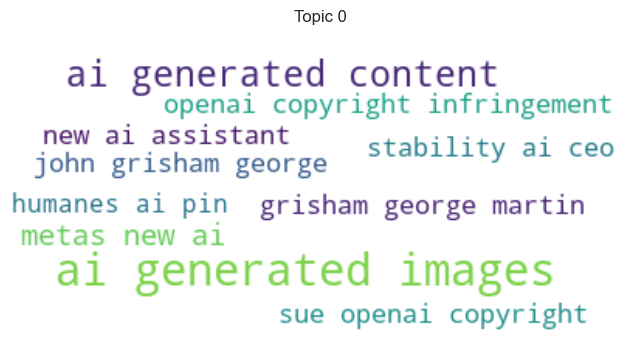

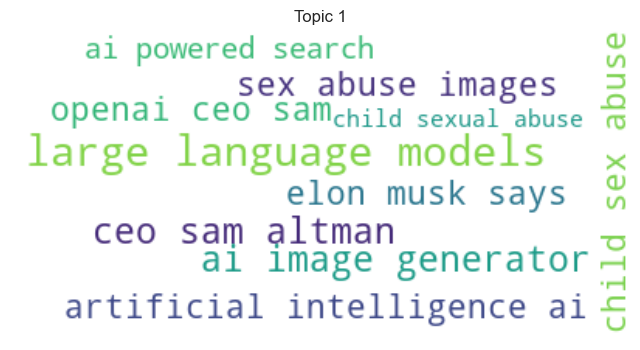

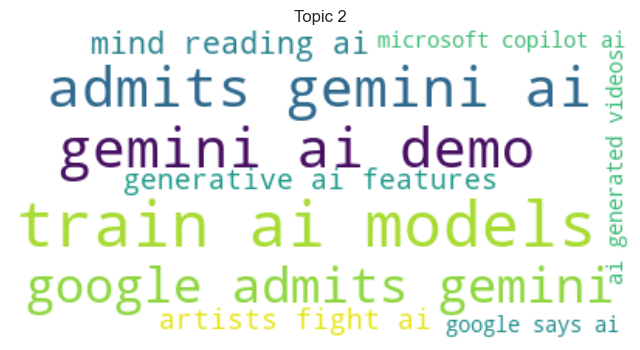

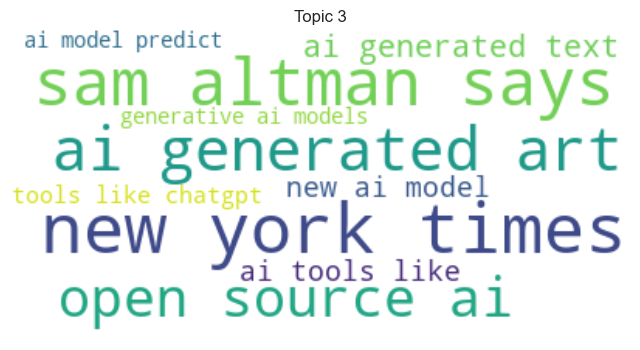

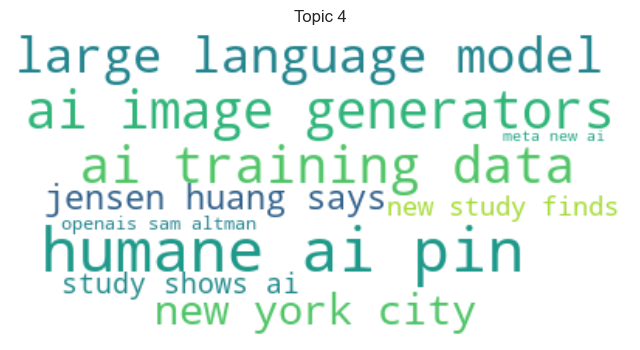

In [130]:
# Visualizing word clouds for each topic for AI tagged posts
for topic_idx, topic in enumerate(lda_model_post_ai.components_):
    word_freq_ai = {vectorizer_for_lda_ai.get_feature_names_out()[i]: topic[i] for i in topic.argsort()[:-11:-1]}
    wordcloud_ai = WordCloud(background_color='white').generate_from_frequencies(word_freq_ai)
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud_ai, interpolation='bilinear')
    plt.title(f"Topic {topic_idx}")
    plt.axis('off')
    plt.show()

In [129]:
# Visualizing topic distributions for a few documents tagged in AI
num_documents_to_visualize_ai = 3
document_topics_ai = lda_model_post_ai.transform(X_post_lda_ai[:num_documents_to_visualize_ai])
for i, document in enumerate(preprocessed_post_text_ai[:num_documents_to_visualize_ai]):
    print(f"Document {i}: {document}")
    print("Topic Distribution:")
    for topic_idx, prob in enumerate(document_topics_ai[i]):
        print(f"Topic {topic_idx}: {prob:.4f}")
    print()

Document 0: sam altman says worries making chatgpt 'something really bad' given potential ai risks
Topic Distribution:
Topic 0: 0.1000
Topic 1: 0.1004
Topic 2: 0.1000
Topic 3: 0.5996
Topic 4: 0.1000

Document 1: hundreds protestants attended sermon nuremberg given chatgpt, told fear death
Topic Distribution:
Topic 0: 0.1000
Topic 1: 0.1000
Topic 2: 0.1000
Topic 3: 0.5999
Topic 4: 0.1000

Document 2: researchers discover chatgpt prefers repeating 25 jokes
Topic Distribution:
Topic 0: 0.0333
Topic 1: 0.0333
Topic 2: 0.8667
Topic 3: 0.0333
Topic 4: 0.0333



In [127]:
# Function for visualizing topic-word distribution
def visualize_topic_word_distribution(lda_model, vectorizer, num_words=10):
    vocab = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words_idx = topic.argsort()[:-num_words - 1:-1]
        top_words = [vocab[i] for i in top_words_idx]
        weights = [topic[i] for i in top_words_idx]
        plt.figure(figsize=(8, 6))
        sns.barplot(x=weights, y=top_words)
        # Adding +1 will increment index by 1
        #plt.title(f'Topic {topic_idx + 1} Word Distribution')
        plt.title(f'Topic {topic_idx} Word Distribution')
        plt.xlabel('Word Weight')
        plt.ylabel('Word')
        plt.show()

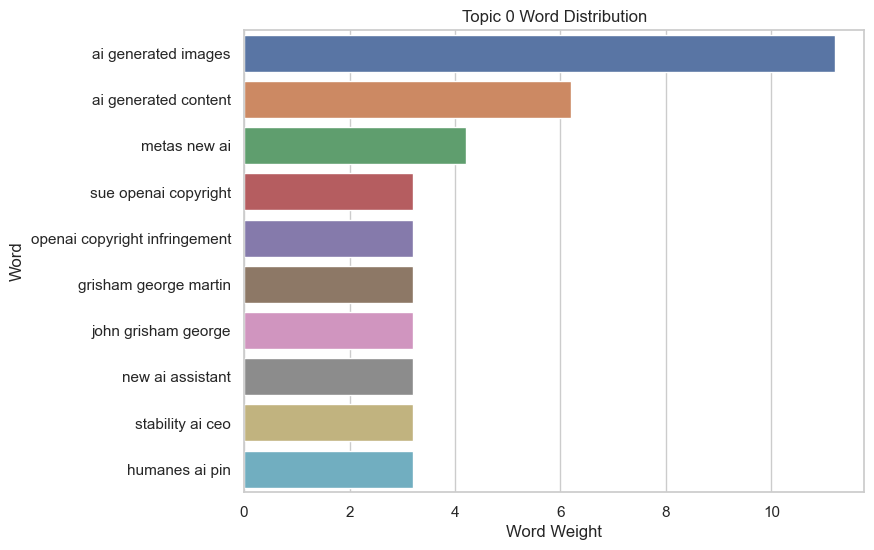

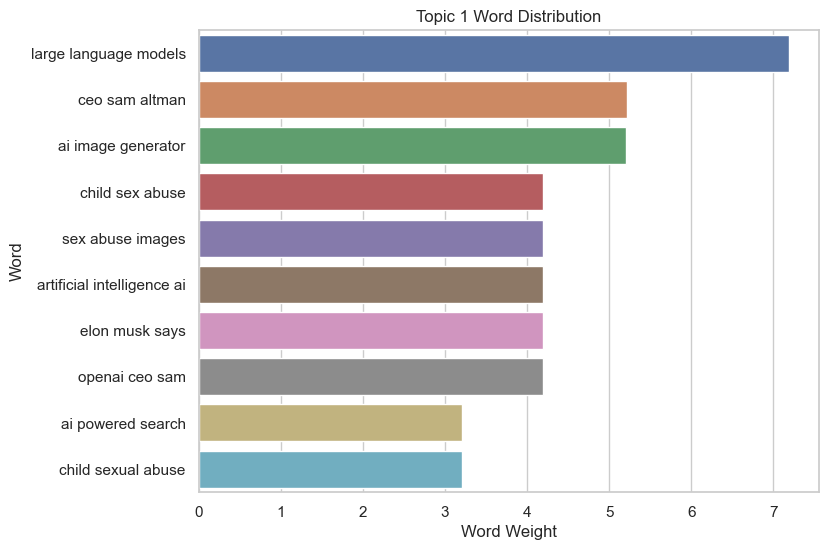

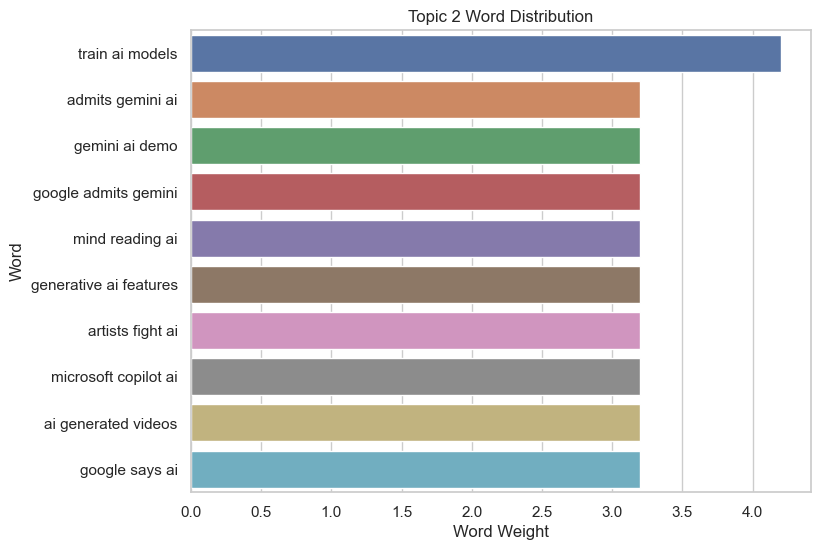

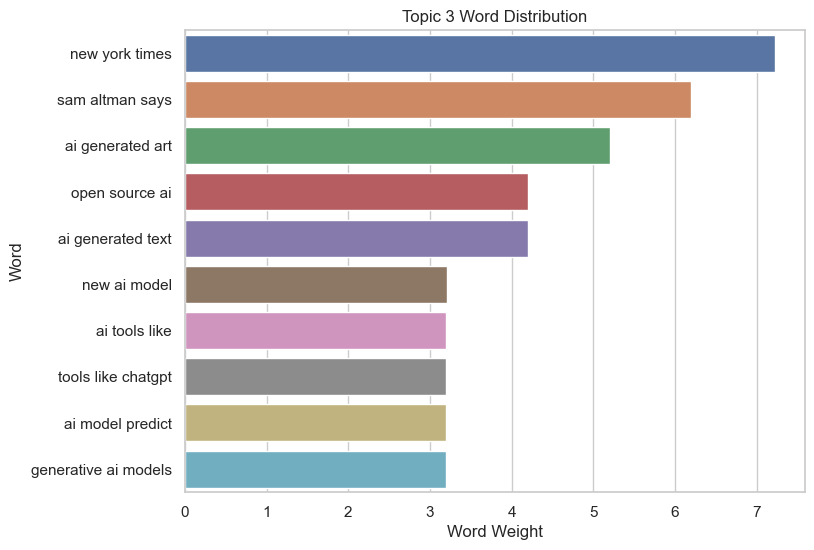

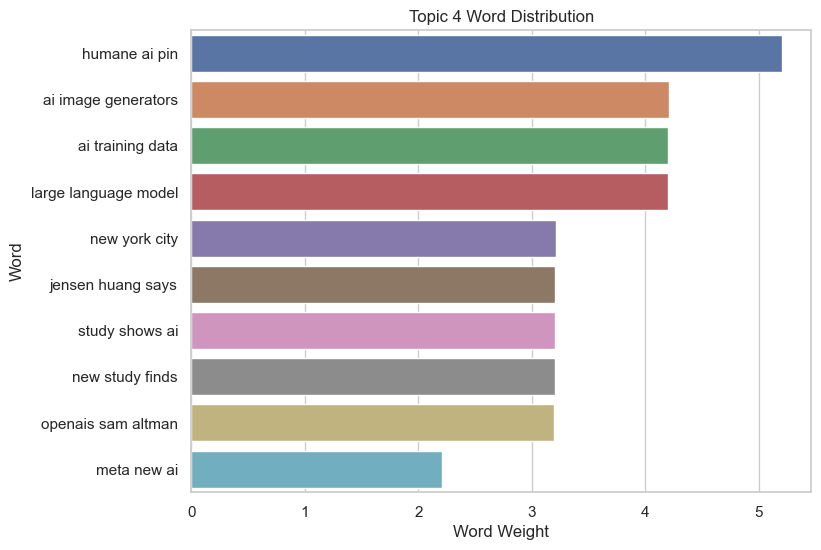

In [128]:
# Visualize the topic-word distribution for AI tagged posts
visualize_topic_word_distribution(lda_model_post_ai, vectorizer_for_lda_ai)

## Comments data analysis

In [67]:
working_df_dedup_comment.head()

post_id comment_id                author            datetime title  url  \
1  145hyey    jnlh1vx  Illustrious_Risk3732 2023-06-09 23:42:43   NaN  NaN   
2  1453u2o    jnjtk7f       ProdigiousPlays 2023-06-09 16:47:51   NaN  NaN   
3  1453u2o    jnjtv9u                YJSubs 2023-06-09 16:49:52   NaN  NaN   
4  1453u2o    jnjusm9           jamnewton22 2023-06-09 16:55:57   NaN  NaN   
5  1453u2o    jnjvwlv            TriLink710 2023-06-09 17:03:15   NaN  NaN   

   score  comments                                               text  \
1    1.0       NaN  He even gives him self Awards to make sure he ...   
2    1.0       NaN  RIF already announced it s shutting down at th...   
3    1.0       NaN              I wonder which sub left on that day     
4    1.0       NaN                  Oh I m sure this will go well lol   
5    1.0       NaN  Oh boy i can t wait for him to say  the devs a...   

   author_post_karma           tag        date  
1            17109.0  Social Media  2023-06-09  
2           118844.0  Social Media  2023-06-09  
3            50085.0  Social Media  2023-06-09  
4           171705.0  Social Media  2023-06-09  
5            70192.0  Social Media  2023-06-09

In [121]:
working_df_dedup_comment.shape

(1415496, 14)

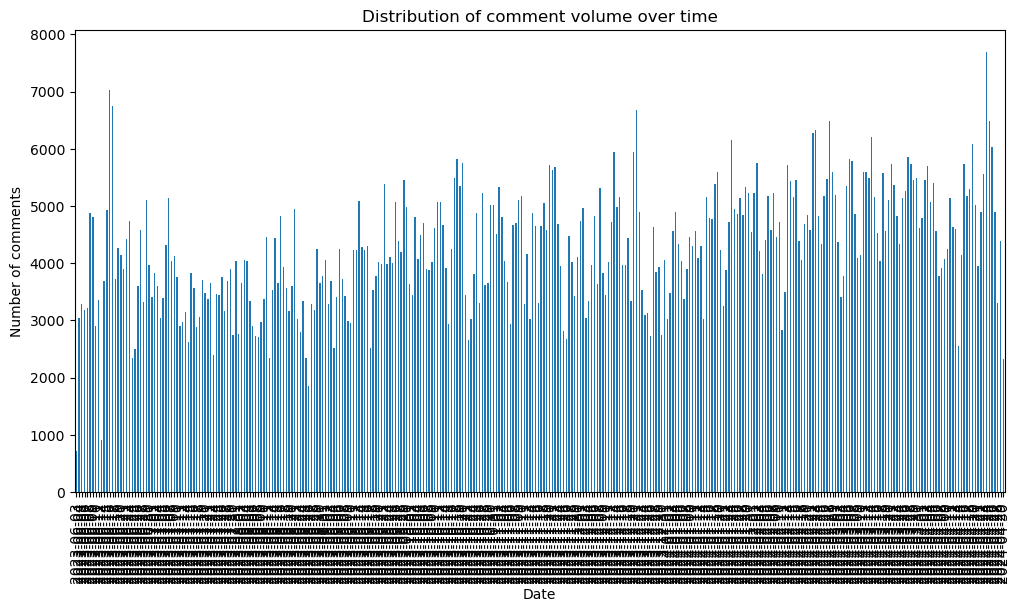

In [68]:
# Grouping data by date  and counting rows
comment_volume_over_time = working_df_dedup_comment.groupby(['date']).size()

# Plotting the bar chart
comment_volume_over_time.plot(kind='bar', figsize=(12, 6))
plt.title('Distribution of comment volume over time')
plt.xlabel('Date')
plt.ylabel('Number of comments')
plt.show()

# too cluttered

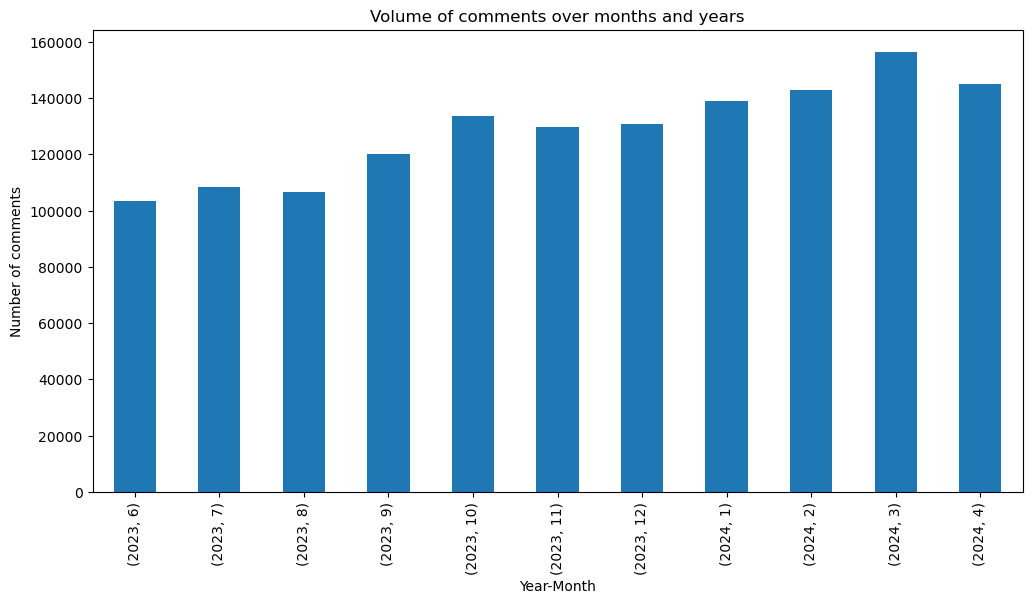

In [69]:
# Extracting year and month from the datetime column
working_df_dedup_comment['year'] = working_df_dedup_comment['datetime'].dt.year
working_df_dedup_comment['month'] = working_df_dedup_comment['datetime'].dt.month

# Grouping data by year and month and counting rows
comment_volume_over_mthyr = working_df_dedup_comment.groupby(['year', 'month']).size()

# Plotting the bar chart
comment_volume_over_mthyr.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Volume of comments over months and years')
plt.xlabel('Year-Month')
plt.ylabel('Number of comments')
plt.show()


C:\Users\veena\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:6827: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


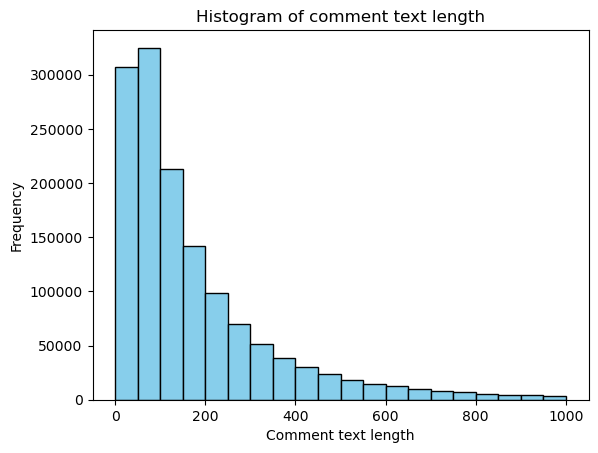

In [70]:
import matplotlib.pyplot as plt

# Calculating the length of the comments to check the distribution
comment_text_lengths = working_df_dedup_comment['text'].apply(len)

# Defining custom bins
# Bins from 0 to 1000 with step size 50
custom_bins = np.arange(0, 1001, 50)  
# Appending infinity to include values above 1000
custom_bins = np.append(custom_bins, np.inf)  

# Plotting the histogram
plt.hist(comment_text_lengths, bins=custom_bins, color='skyblue', edgecolor='black')
plt.title('Histogram of comment text length')
plt.xlabel('Comment text length')
plt.ylabel('Frequency')
plt.show()


C:\Users\veena\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:6827: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


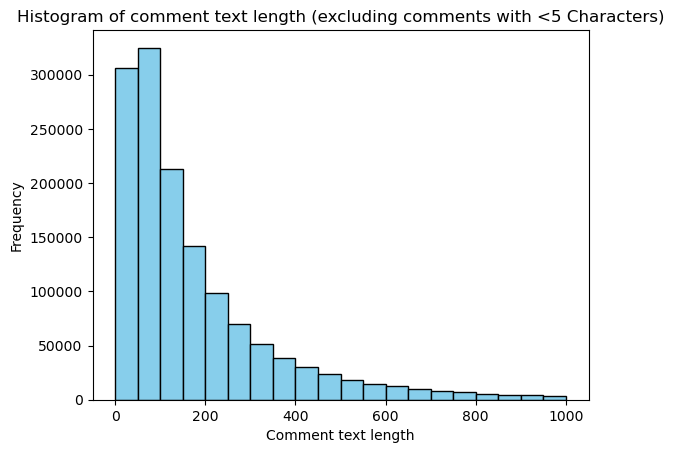

In [71]:
# Filtering out comments with less than 5 characters
comments_with_over5charlen = working_df_dedup_comment[working_df_dedup_comment['text'].str.len() >= 5]

# Getting the lengths of the filtered comments
comment_text_lengths_v2 = comments_with_over5charlen['text'].apply(len)

# Defining custom bins
# Bins from 0 to 1000 with step size 50
custom_bins = np.arange(0, 1001, 50)  
# Appending infinity to include values above 1000
custom_bins = np.append(custom_bins, np.inf)  

# Plotting the histogram with custom bins
plt.hist(comment_text_lengths_v2, bins=custom_bins, color='skyblue', edgecolor='black')
plt.title('Histogram of comment text length (excluding comments with <5 Characters)')
plt.xlabel('Comment text length')
plt.ylabel('Frequency')
plt.show()


In [72]:
print("Raw comments data shape:")
print(working_df_dedup_comment.shape[0])  

print("\nComments dataset shape after excluding comments with <5 characters:")
print(comments_with_over5charlen.shape[0])

comment_df_size_change = (working_df_dedup_comment.shape[0] - comments_with_over5charlen.shape[0])/working_df_dedup_comment.shape[0]
percentage_change = comment_df_size_change * 100

print(f"\n% difference: {percentage_change:.2f}%")

Raw comments data shape:
1415496

Comments dataset shape after excluding comments with <5 characters:
1414578

% difference: 0.06%


C:\Users\veena\AppData\Local\Temp\ipykernel_54088\1421957113.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_with_over5charlen['comment_length'] = comments_with_over5charlen['text'].apply(len)


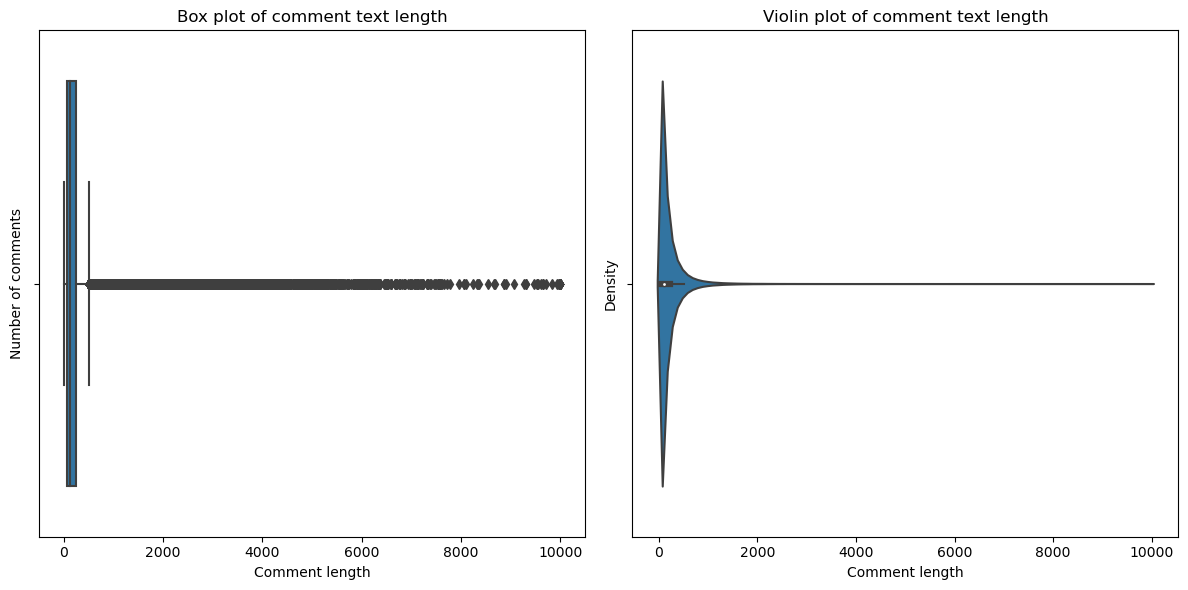

In [73]:
# Calculate the length of each comment text
comments_with_over5charlen['comment_length'] = comments_with_over5charlen['text'].apply(len)

# Setting up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plotting box plot of comment length
sns.boxplot(x='comment_length', data=comments_with_over5charlen, ax=axes[0])
axes[0].set_title('Box plot of comment text length')
axes[0].set_xlabel('Comment length')
axes[0].set_ylabel('Number of comments')

# Plotting violin plot of comment length
sns.violinplot(x='comment_length', data=comments_with_over5charlen, ax=axes[1])
axes[1].set_title('Violin plot of comment text length')
axes[1].set_xlabel('Comment length')
axes[1].set_ylabel('Density')

# Show the plots
plt.tight_layout()
plt.show()

C:\Users\veena\AppData\Local\Temp\ipykernel_54088\2221743275.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_with_over5charlen['tag'].fillna('No tag', inplace=True)


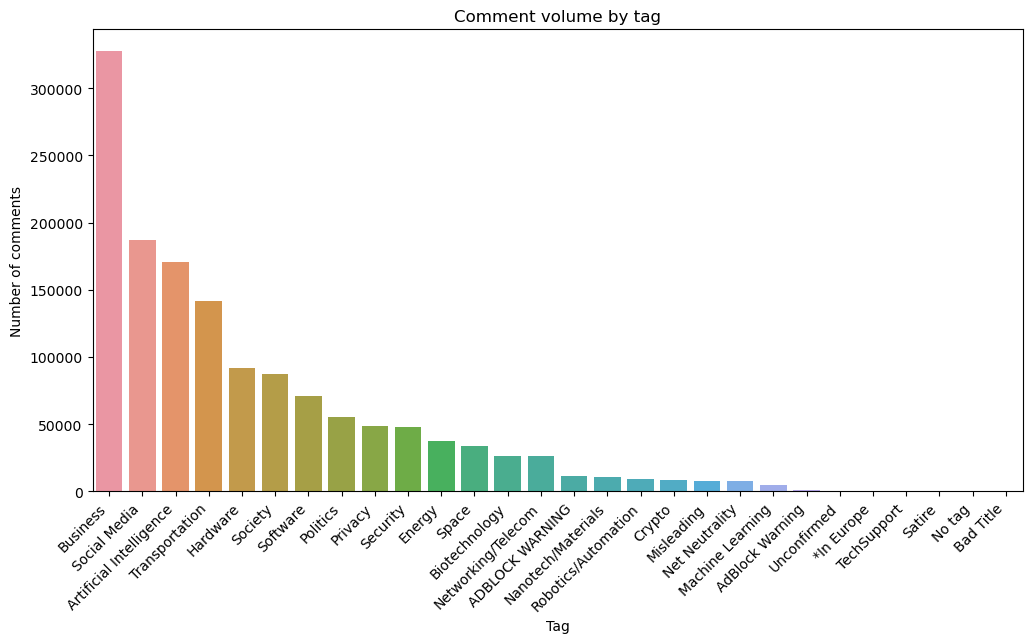

In [74]:
# Filling missing values in tag column with 'No tag'
comments_with_over5charlen['tag'].fillna('No tag', inplace=True)

# Visualizing the count of comments by tag
plt.figure(figsize=(12, 6))
sns.countplot(data=comments_with_over5charlen, x='tag', order=comments_with_over5charlen['tag'].value_counts().index)
plt.title('Comment volume by tag')
plt.xlabel('Tag')
plt.ylabel('Number of comments')
plt.xticks(rotation=45, ha='right')
plt.show()


There's an interesting difference in distribution - business is the largest tag by comment volume compared to AI in posts

In [75]:
# Grouping the data by post_id + tag and calculating the count of comments
comments_per_post_by_tag = comments_with_over5charlen.groupby(['post_id', 'tag'])['comment_id'].count().reset_index()
# Renaming the 'comment_id' column to 'comments_per_post'
comments_per_post_by_tag = comments_per_post_by_tag.rename(columns={'comment_id': 'comments_per_post'})

In [76]:
comments_per_post_by_tag

post_id                      tag  comments_per_post
0      13z2rrd                 Politics                  1
1      13z2s7w                 Business                166
2      13z4ajj                 Business                  1
3      13zb517                 Politics                484
4      13zcsvn                 Business                  2
...        ...                      ...                ...
13766  1cgpnok  Artificial Intelligence                  9
13767  1cgpszd                 Security                  2
13768  1cgq5j6                 Business                 87
13769  1cgqpel                 Security                  3
13770  1cgrbh5                   Energy                  1

[13771 rows x 3 columns]

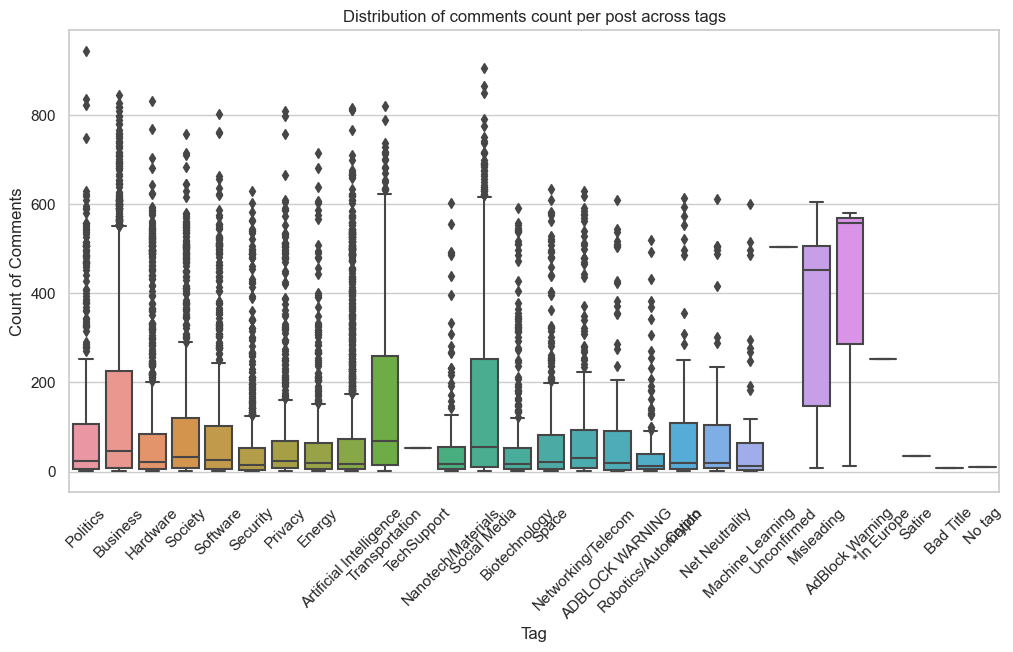

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# Setting the style of the seaborn plot
sns.set(style="whitegrid")

# Creating a boxplot for each tag
plt.figure(figsize=(12, 6))
sns.boxplot(data=comments_per_post_by_tag, x='tag', y='comments_per_post')
plt.title('Distribution of comments count per post across tags')
plt.xlabel('Tag')
plt.ylabel('Count of Comments')
plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability
plt.show()
# not very clear, can try swarm plot or strip plot instead

#### There's an interesting pattern - certain tags like politics, social media, business, hardware, society, AI etc seem to be quite opinionated tags since they have wider ranges of comments per post. This can better be visualized as a strip plot.

#### This is a dynamic plot and it will not display static view

In [78]:
import plotly.express as px

# Creating an interactive strip plot using Plotly Express
fig = px.strip(comments_per_post_by_tag, x='tag', y='comments_per_post', title='Distribution of comment count per post across tags',
               labels={'tag': 'Tag', 'comments_per_post': 'Comments per post'})
fig.update_layout(xaxis={'categoryorder':'total descending'})  # Sort the x-axis categories by total count
fig.show()

<Figure size 1200x600 with 0 Axes>

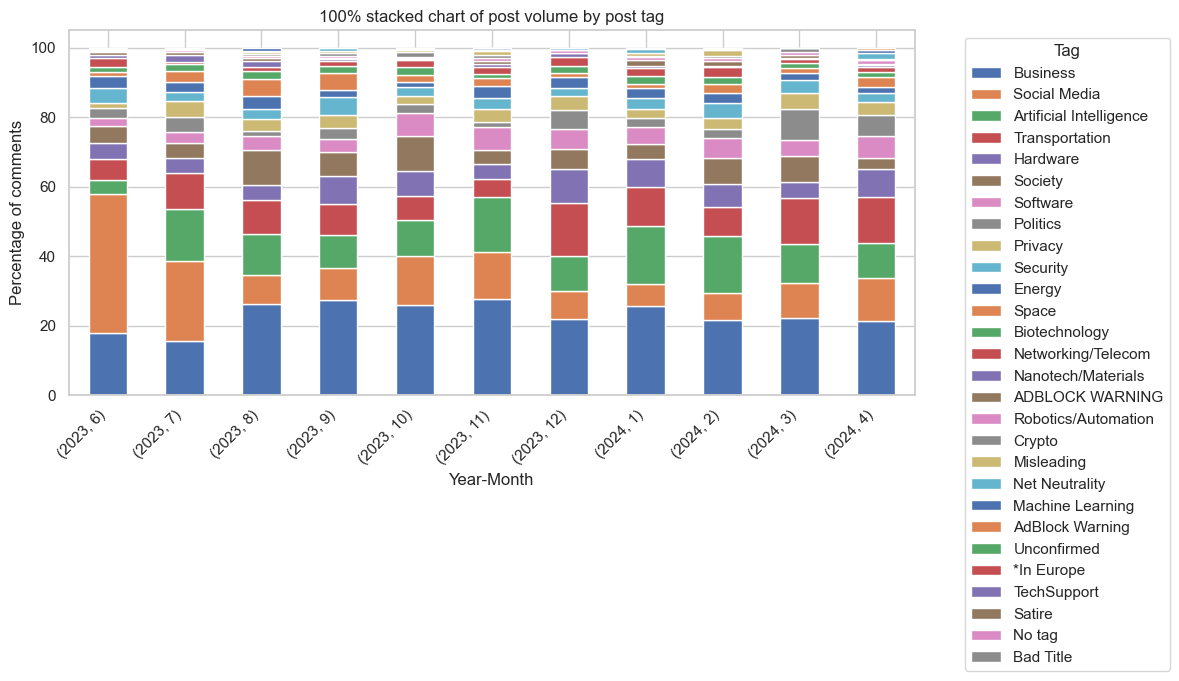

In [79]:
# Creating a pivot table to aggregate comment volume by year, month, and tag
pivot_table_com_tag = comments_with_over5charlen.pivot_table(index=['year', 'month'], columns='tag', 
                                                       values='comment_id', aggfunc='count', fill_value=0)

# Calculating the percentage of comment volume for each tag within each month
pivot_table_com_tag_percentage = pivot_table_com_tag.div(pivot_table_com_tag.sum(axis=1), axis=0) * 100

# Sorting the columns of the pivot table 
pivot_table_com_tag_percentage_sorted = pivot_table_com_tag_percentage[pivot_table_com_tag_percentage.sum().
                                                               sort_values(ascending=False).index]

# Plotting 100% stacked bar chart
plt.figure(figsize=(12, 6))
pivot_table_com_tag_percentage_sorted.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('100% stacked chart of post volume by post tag')
plt.xlabel('Year-Month')
plt.ylabel('Percentage of comments')
plt.legend(title='Tag', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [80]:
# Converting the pivot table to a tabular summary
summary_df_com_tag_share = pivot_table_com_tag_percentage_sorted.reset_index()

summary_df_com_tag_share

tag  year  month   Business  Social Media  Artificial Intelligence  \
0    2023      6  17.880461     39.906035                 4.193548   
1    2023      7  15.509997     23.211895                14.704714   
2    2023      8  26.357259      8.147779                11.930543   
3    2023      9  27.448202      9.181071                 9.406931   
4    2023     10  25.822476     14.257992                10.370948   
5    2023     11  27.650100     13.586202                15.888254   
6    2023     12  22.034274      7.942249                10.172136   
7    2024      1  25.537486      6.361354                16.804649   
8    2024      2  21.507789      7.902780                16.254224   
9    2024      3  22.263581     10.127019                11.218133   
10   2024      4  21.367332     12.380742                10.065700   

tag  Transportation  Hardware    Society  Software  Politics  ...  Misleading  \
0          5.972101  4.740870   4.762182  2.321999  2.892570  ...    0.000000   
1         10.397562  4.359791   4.257284  3.308861  4.200028  ...    0.000000   
2          9.813773  4.168741  10.259854  3.896397  1.463144  ...    0.577557   
3          8.870202  8.285133   6.869135  3.724601  2.969513  ...    0.580068   
4          6.929699  7.197177  10.023301  6.688445  2.389319  ...    0.504986   
5          5.145084  4.240624   4.076246  6.540361  1.597469  ...    1.159129   
6         15.181733  9.753841   5.690187  5.879069  5.443186  ...    0.000000   
7         11.043179  8.214232   4.348076  4.988959  2.398095  ...    0.799845   
8          8.500764  6.723638   7.428179  5.612495  2.671649  ...    1.845828   
9         13.231513  4.452716   7.402433  4.578073  8.936132  ...    0.011512   
10        13.084028  8.308175   2.972732  6.337177  6.174827  ...    0.289467   

tag  Net Neutrality  Machine Learning  AdBlock Warning  Unconfirmed  \
0          0.150150          0.036811         0.000000      0.48823   
1          0.092349          0.490373         0.000000      0.00000   
2          0.227266          0.999221         0.000000      0.00000   
3          0.951778          0.052506         0.000000      0.00000   
4          0.202294          0.519222         0.009740      0.00000   
5          0.120389          0.487730         0.000000      0.00000   
6          0.567413          0.039000         0.000000      0.00000   
7          1.222065          0.445237         0.000000      0.00000   
8          0.310559          0.284621         0.000000      0.00000   
9          0.008314          0.075470         0.000000      0.00000   
10         1.737490          0.664599         0.786879      0.00000   

tag  *In Europe  TechSupport    Satire    No tag  Bad Title  
0      0.000000     0.050373  0.000000  0.000000   0.000000  
1      0.000000     0.000000  0.000000  0.000000   0.000000  
2      0.000000     0.000000  0.000000  0.000000   0.000000  
3      0.000000     0.000000  0.000000  0.000000   0.000000  
4      0.000000     0.000000  0.000000  0.000000   0.000000  
5      0.195246     0.000000  0.027782  0.008489   0.006946  
6      0.000000     0.000000  0.000000  0.000000   0.000000  
7      0.000000     0.000000  0.000000  0.000000   0.000000  
8      0.000000     0.000000  0.000000  0.000000   0.000000  
9      0.000000     0.000000  0.000000  0.000000   0.000000  
10     0.000000     0.000000  0.000000  0.006909   0.000000  

[11 rows x 30 columns]

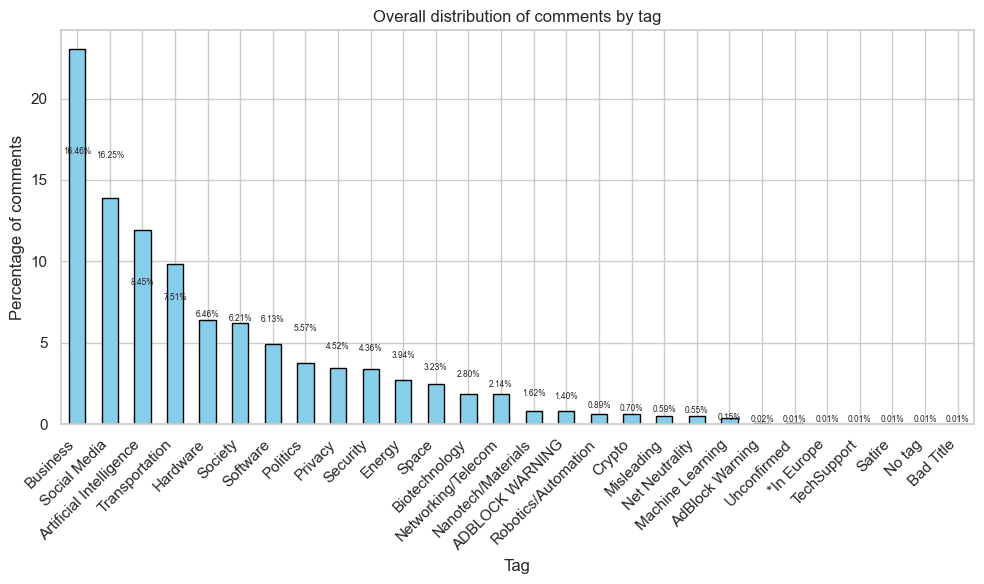

Cumulative percentage of comments by tag:
tag
Business                    23.034451
Social Media                36.944007
Artificial Intelligence     48.853987
Transportation              58.687590
Hardware                    65.091676
Society                     71.281640
Software                    76.179498
Politics                    79.919128
Privacy                     83.335890
Security                    86.715648
Energy                      89.440170
Space                       91.889926
Biotechnology               93.766788
Networking/Telecom          95.595875
Nanotech/Materials          96.419814
ADBLOCK WARNING             97.210576
Robotics/Automation         97.853861
Crypto                      98.451469
Misleading                  98.975868
Net Neutrality              99.484056
Machine Learning            99.856310
AdBlock Warning             99.928730
Unconfirmed                 99.973114
*In Europe                  99.990864
TechSupport                 99.995443
Sati

In [81]:
# Calculating the percentage of comment volume for each tag across all months and years
overall_percentage_com_tag = pivot_table_com_tag_percentage_sorted.mean()

# Plotting the 100% stacked bar chart with percentage values
plt.figure(figsize=(10, 6))
ax = overall_percentage_com_tag.plot(kind='bar', color='skyblue', edgecolor='black')
for idx, value in enumerate(overall_percentage_tag):
    ax.annotate(f'{value:.2f}%', (idx, value), ha='center', va='bottom', fontsize = 6)

plt.title('Overall distribution of comments by tag')
plt.xlabel('Tag')
plt.ylabel('Percentage of comments')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Cumulative percentage to identify the pareto
overall_cumulative_percentage_com_tag = overall_percentage_com_tag.cumsum()
print("Cumulative percentage of comments by tag:")
print(overall_cumulative_percentage_com_tag)


#### The top 8 tags account for ~80% of the comment volume - this is a pareto like effect

#### n-grams of title text - comments

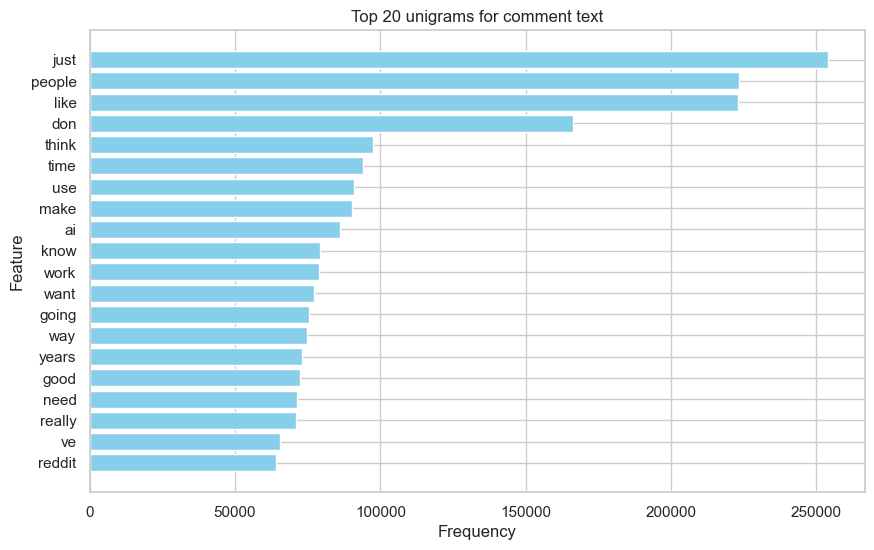

In [82]:
# Initializing CountVectorizer for unigrams
unigram_vectorizer_com = CountVectorizer(stop_words='english')

# Fitting and transform the 'text' column to extract unigrams
unigram_matrix_com = unigram_vectorizer_com.fit_transform(comments_with_over5charlen['text'])

# Getting feature names (unigrams)
unigram_feature_names_com = unigram_vectorizer_com.get_feature_names_out()


# Plotting top 20 unigrams
top_unigrams_com = sorted(zip(unigram_feature_names_com, unigram_matrix_com.sum(axis=0).tolist()[0]), 
                      key=lambda x: x[1], reverse=True)[:20]
unigram_names_com, unigram_counts_com = zip(*top_unigrams_com)
plot_top_features(unigram_names_com, unigram_counts_com, 'Top 20 unigrams for comment text')

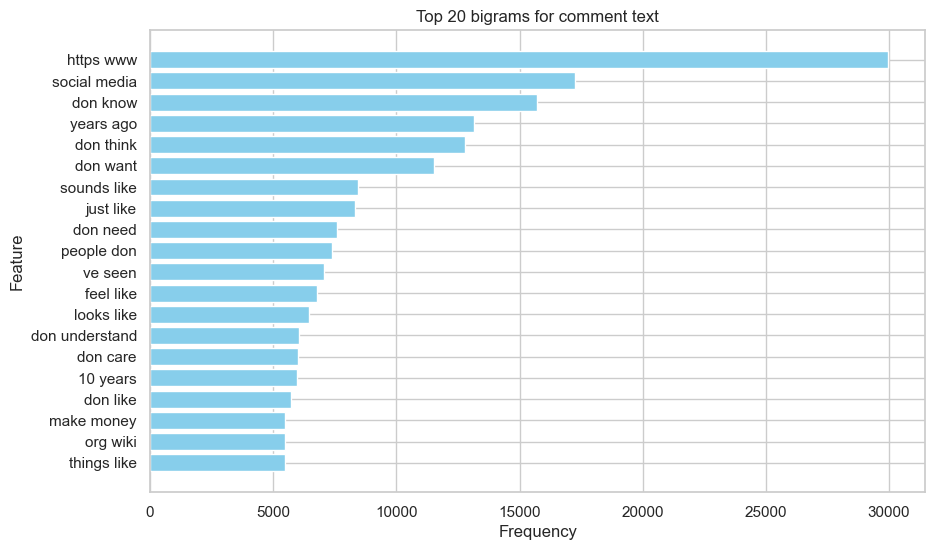

In [83]:
# Initializing CountVectorizer for bigrams
bigram_vectorizer_com = CountVectorizer(ngram_range=(2, 2), stop_words='english')

# Fitting and transform the 'text' column to extract bigrams
bigram_matrix_com = bigram_vectorizer_com.fit_transform(comments_with_over5charlen['text'])

# Getting feature names (bigrams)
bigram_feature_names_com = bigram_vectorizer_com.get_feature_names_out()

# Plotting top 20 bigrams
top_bigrams_com = sorted(zip(bigram_feature_names_com, bigram_matrix_com.sum(axis=0).tolist()[0]), 
                     key=lambda x: x[1], reverse=True)[:20]
bigram_names_com, bigram_counts_com = zip(*top_bigrams_com)
plot_top_features(bigram_names_com, bigram_counts_com, 'Top 20 bigrams for comment text')

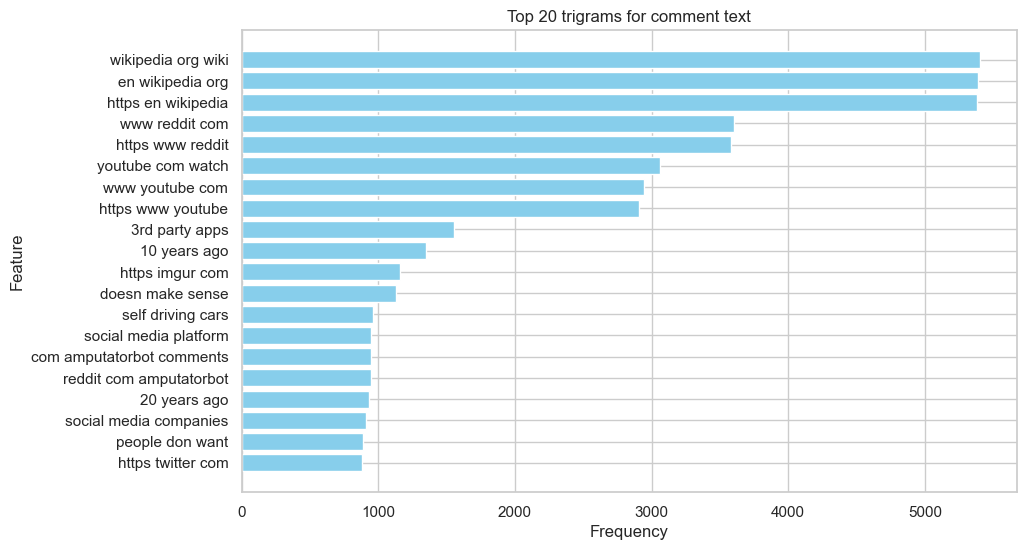

In [84]:
# Initializing CountVectorizer for trigrams
trigram_vectorizer_com = CountVectorizer(ngram_range=(3, 3), stop_words='english')

# Fitting and transform the 'text' column to extract trigrams
trigram_matrix_com = trigram_vectorizer_com.fit_transform(comments_with_over5charlen['text'])

# Getting feature names (trigrams)
trigram_feature_names_com = trigram_vectorizer_com.get_feature_names_out()

# Plotting top 20 trigrams
top_trigrams_com = sorted(zip(trigram_feature_names_com, trigram_matrix_com.sum(axis=0).tolist()[0]), 
                      key=lambda x: x[1], reverse=True)[:20]
trigram_names_com, trigram_counts_com = zip(*top_trigrams_com)
plot_top_features(trigram_names_com, trigram_counts_com, 'Top 20 trigrams for comment text')

#### Sentiment analysis - comments

In [85]:
# Applying the function to classify sentiment for each comment text
comments_with_over5charlen['sentiment'] = comments_with_over5charlen['text'].apply(get_sentiment)

C:\Users\veena\AppData\Local\Temp\ipykernel_54088\4109661461.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



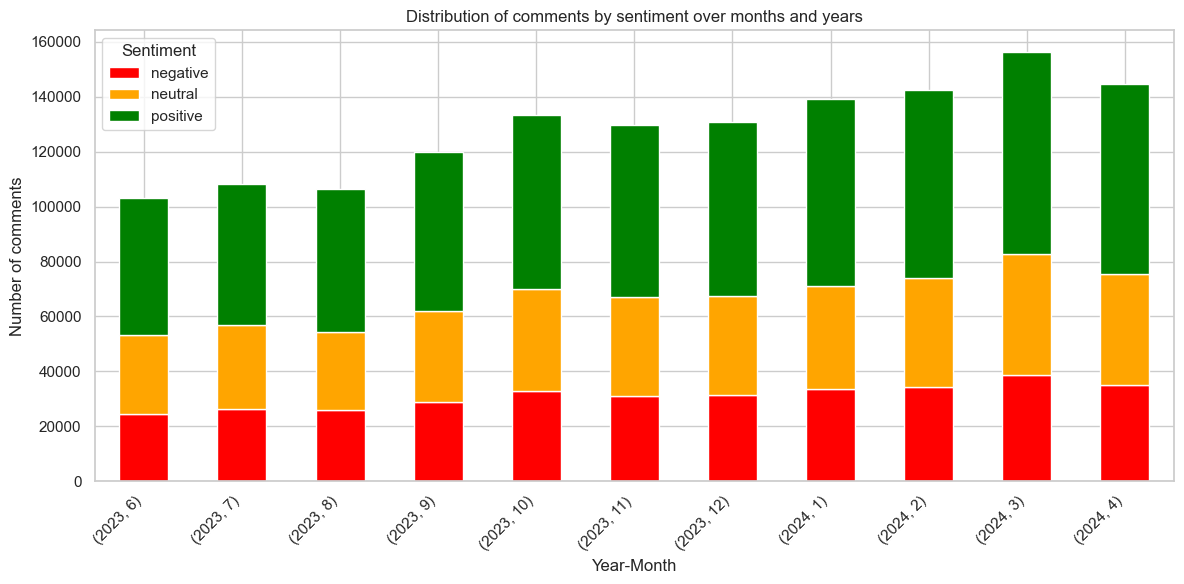

In [125]:
# Grouping data by year_month and sentiment to calculate counts
sentiment_counts_comments_mthyr = comments_with_over5charlen.groupby(['year', 'month', 'sentiment']).size().unstack(fill_value=0)

# Defining custom colors for each sentiment
senti_colors_comments = {'negative': 'red', 'neutral': 'orange', 'positive': 'green'}

# Reordering the sentiments to match the order of the stacked bar chart
comment_sentiments_ordered = sentiment_counts_comments_mthyr.columns

# Create a list of colors in the same order as the sentiments
colors_ordered_com = [senti_colors_comments[sentiment] for sentiment in comment_sentiments_ordered]

# Plotting stacked bar chart with custom colors
sentiment_counts_comments_mthyr.plot(kind='bar', stacked=True, figsize=(12, 6), color=senti_colors_comments.values())
plt.title('Distribution of comments by sentiment over months and years')
plt.xlabel('Year-Month')
plt.ylabel('Number of comments')
plt.xticks(rotation=45, ha='right')  # Rotating x-axis labels for better readability
plt.legend(title='Sentiment', labels=senti_colors_comments.keys())
plt.tight_layout()
plt.show()

In [90]:
# Grouping data by year, month, and sentiment and counting rows
comment_volume_over_time_sentiment = comments_with_over5charlen.groupby(['year', 'month', 'sentiment']).size().unstack(fill_value=0)

# Resetting index to make year and month columns accessible
comment_volume_over_time_sentiment = comment_volume_over_time_sentiment.reset_index()

# Displaying the tabular summary
print("Tabular summary of comment volume by sentiment over time:\n")
print(comment_volume_over_time_sentiment)

Tabular summary of comment volume by sentiment over time:

sentiment  year  month  negative  neutral  positive
0          2023      6     24637    28606     49987
1          2023      7     26203    30538     51544
2          2023      8     25979    28210     52294
3          2023      9     28941    33170     57875
4          2023     10     32860    37204     63405
5          2023     11     30860    36354     62366
6          2023     12     31245    36025     63499
7          2024      1     33480    37731     67816
8          2024      2     34394    39508     68744
9          2024      3     38859    43852     73643
10         2024      4     35139    40264     69346


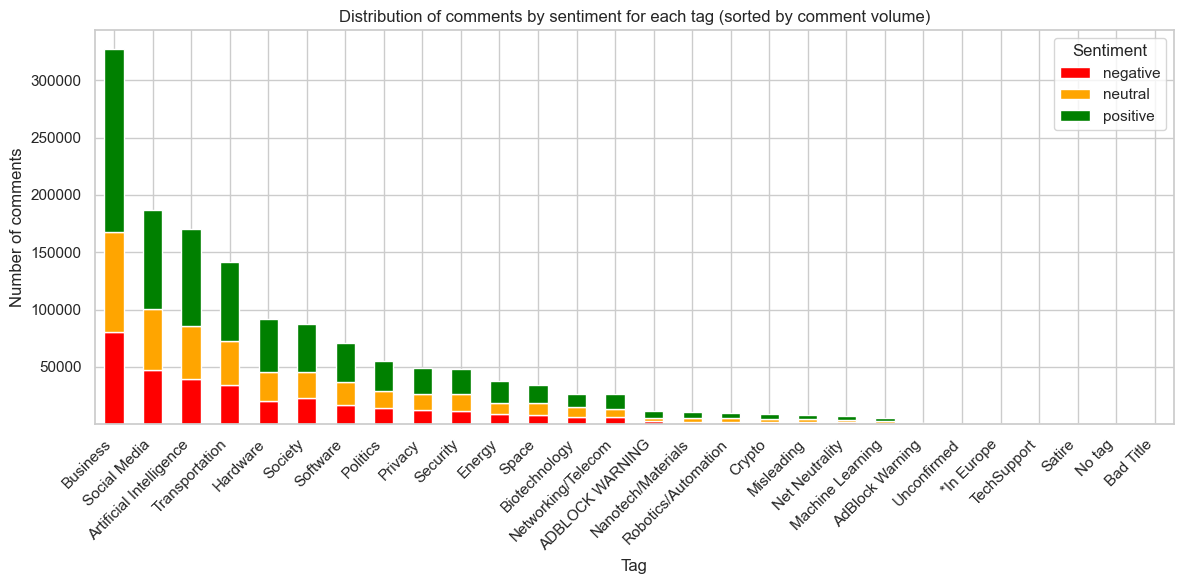

In [92]:
# Grouping data by tag and sentiment to calculate counts
sentiment_counts_by_tag_comments = comments_with_over5charlen.groupby(['tag', 'sentiment']).size().unstack(fill_value=0)

# Calculate total comment volume for each tag
tag_comment_volume = comments_with_over5charlen.groupby('tag').size().sort_values(ascending=False)

# Reorder the sentiment_counts_by_tag DataFrame based on the sorted tags
sentiment_counts_by_tag_sorted_comments = sentiment_counts_by_tag_comments.loc[tag_comment_volume.index]

# Plotting stacked bar chart for sentiment distribution by tag
sentiment_counts_by_tag_sorted_comments.plot(kind='bar', stacked=True, figsize=(12, 6), color=senti_colors_comments.values())
plt.title('Distribution of comments by sentiment for each tag (sorted by comment volume)')
plt.xlabel('Tag')
plt.ylabel('Number of comments')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Sentiment', labels=senti_colors_comments.keys())
plt.tight_layout()
plt.show()


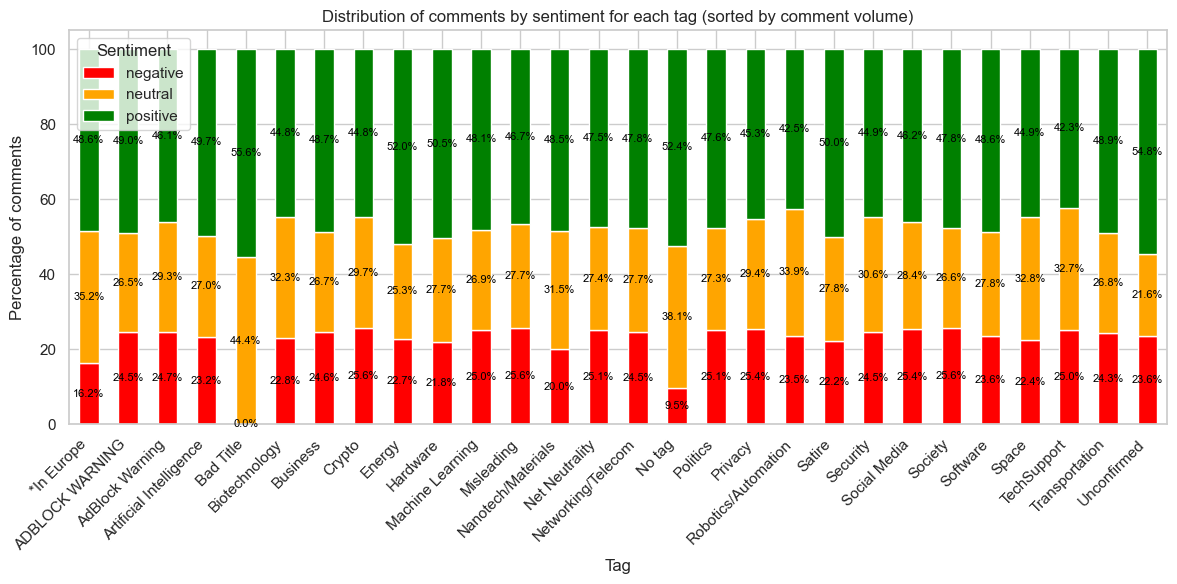

In [94]:
# Calculate the total comment volume for each tag
tag_total_comments = sentiment_counts_by_tag_sorted_comments.sum(axis=1)

# Calculate the percentage of comments for each sentiment within each tag
sentiment_percentages_by_tag_comments = sentiment_counts_by_tag_comments.div(tag_total_comments, axis=0) * 100

# Plotting 100% stacked bar chart for sentiment distribution by tag
sentiment_percentages_by_tag_comments.plot(kind='bar', stacked=True, figsize=(12, 6), color=senti_colors_comments.values())
plt.title('Distribution of comments by sentiment for each tag (sorted by comment volume)')
plt.xlabel('Tag')
plt.ylabel('Percentage of comments')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Sentiment', labels=senti_colors_comments.keys(), loc='upper left')
plt.tight_layout()

# Add labels to the bars
for i in range(sentiment_percentages_by_tag_comments.shape[0]):
    total_height = 0
    for j in range(sentiment_percentages_by_tag_comments.shape[1]):
        plt.text(i, total_height + sentiment_percentages_by_tag_comments.iloc[i, j] / 2,
                 f"{sentiment_percentages_by_tag_comments.iloc[i, j]:.1f}%",
                 ha='center', va='center', color='black', fontsize=8)
        total_height += sentiment_percentages_by_tag_comments.iloc[i, j]

plt.show()


#### Majority of the comments have neutral sentiment

### Text cleaning and pre-processing - comments

In [95]:
# Applying the cleaning function to the text column
comments_with_over5charlen['comment_clean'] = comments_with_over5charlen['text'].apply(clean_text_function_reddit)

C:\Users\veena\AppData\Local\Temp\ipykernel_54088\1057376177.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [96]:
# Filtering out comments with less than 5 characters
comments_with_over5charlen_clean = comments_with_over5charlen[comments_with_over5charlen['comment_clean'].str.len() >= 5]

In [97]:
print("Intermediate comments data shape:")
print(comments_with_over5charlen.shape[0])  

print("\nCleaned comments dataset shape after excluding cleaned comments with <5 characters:")
print(comments_with_over5charlen_clean.shape[0])

comment_df_size_change_clean = (comments_with_over5charlen.shape[0] - comments_with_over5charlen_clean.shape[0])/comments_with_over5charlen.shape[0]
percentage_change_clean = comment_df_size_change_clean * 100

print(f"\n% difference: {percentage_change_clean:.2f}%")

Intermediate comments data shape:
1414578

Cleaned comments dataset shape after excluding cleaned comments with <5 characters:
1405143

% difference: 0.67%


C:\Users\veena\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:6827: RuntimeWarning:

invalid value encountered in multiply



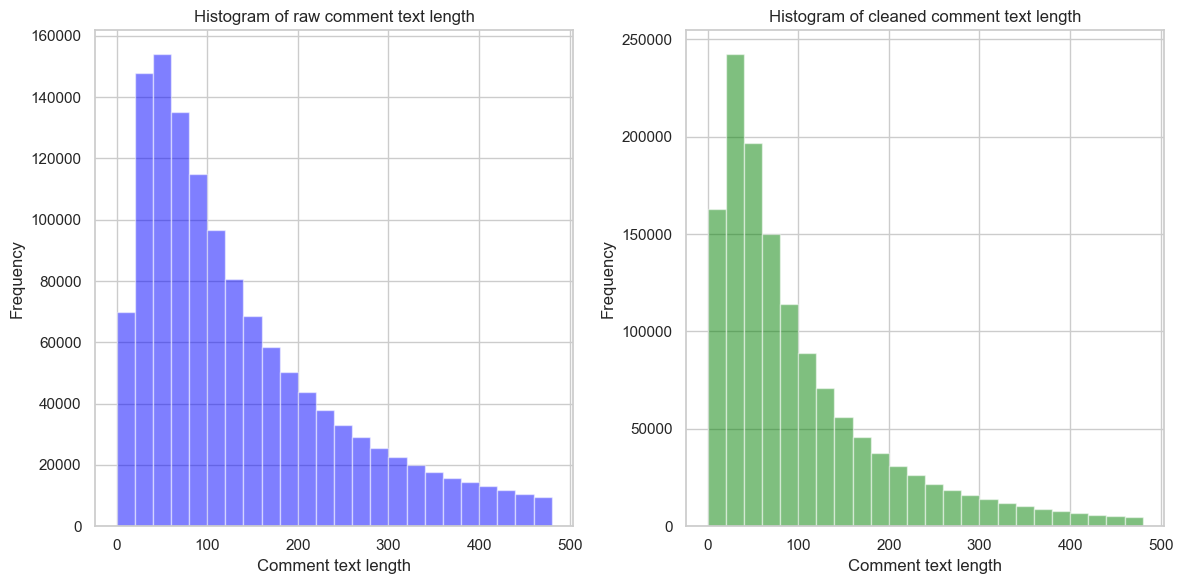

In [98]:
# Calculating the length of the text in the raw and cleaned text columns
comments_raw_text_lengths = comments_with_over5charlen_clean['text'].apply(len)
comments_cleaned_text_lengths = comments_with_over5charlen_clean['comment_clean'].apply(len)

# Defining custom bins
# Bins from 0 to 500 with step size 20
custom_bins_clean = np.arange(0, 500, 20)  
# Appending infinity to include values above 500
custom_bins_clean = np.append(custom_bins_clean, np.inf)  

# Defining subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plotting histogram for raw text lengths
axes[0].hist(comments_raw_text_lengths, bins=custom_bins_clean, alpha=0.5, color='blue')
axes[0].set_title('Histogram of raw comment text length')
axes[0].set_xlabel('Comment text length')
axes[0].set_ylabel('Frequency')

# Plotting histogram for cleaned text lengths
axes[1].hist(comments_cleaned_text_lengths, bins=custom_bins_clean, alpha=0.5, color='green')
axes[1].set_title('Histogram of cleaned comment text length')
axes[1].set_xlabel('Comment text length')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


Looking at the 2 charts, we can see that the concentration of the lower text length increases after cleaning i.e. relatively lower text length become even lower. This indicates that there are a lot of characters getting removed due to our cleaning steps. This is the nature of the comments data on reddit (multiple parent-child comments, single word replies and references) and this reduction is expected.

C:\Users\veena\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:6827: RuntimeWarning:

invalid value encountered in multiply



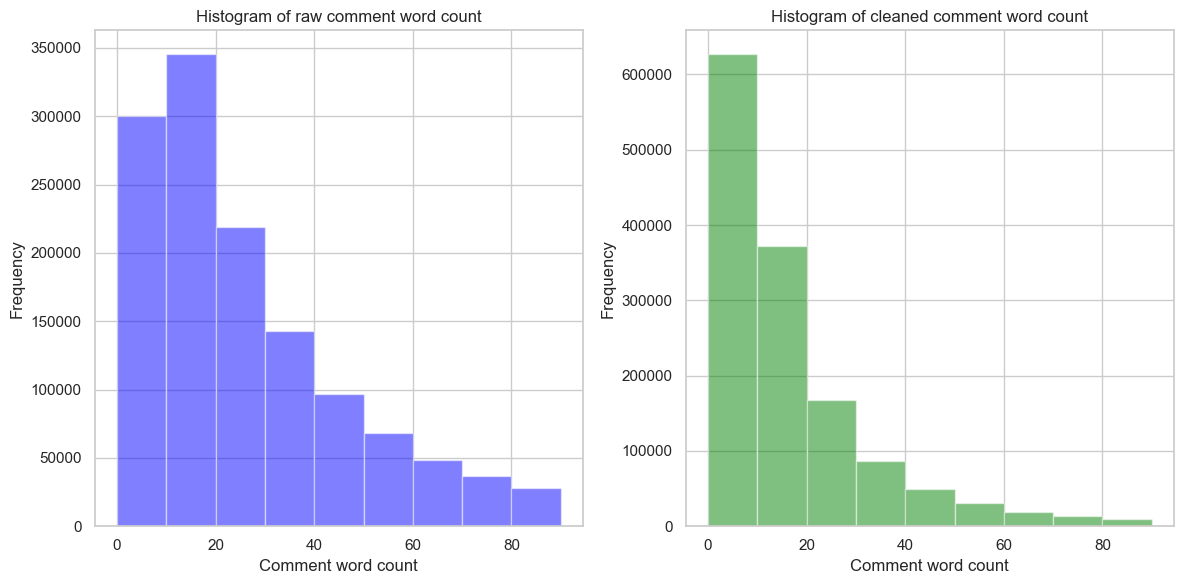

In [99]:
# Calculating the word count of the text in the raw and cleaned text columns
comments_raw_text_words = comments_with_over5charlen_clean['text'].str.split().apply(len)
comments_cleaned_text_words = comments_with_over5charlen_clean['comment_clean'].str.split().apply(len)

# Defining custom bins
# Bins from 0 to 100 with step size 10
custom_bins_clean_words = np.arange(0, 100, 10)  
# Appending infinity to include values above 100
custom_bins_clean_words = np.append(custom_bins_clean_words, np.inf)  

# Creating subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plotting histogram for raw word counts
axes[0].hist(comments_raw_text_words, bins=custom_bins_clean_words, alpha=0.5, color='blue')
axes[0].set_title('Histogram of raw comment word count')
axes[0].set_xlabel('Comment word count')
axes[0].set_ylabel('Frequency')

# Plotting histogram for cleaned word counts
axes[1].hist(comments_cleaned_text_words, bins=custom_bins_clean_words, alpha=0.5, color='green')
axes[1].set_title('Histogram of cleaned comment word count')
axes[1].set_xlabel('Comment word count')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


Similar trend occuring for words

### Writing output data that will go into streamlit

Currently manual for security reasons

In [100]:
# Writing posts cleaned file to CSV

# Creating a copy of the final posts df 
posts_with_comments_final = posts_with_comments_only.copy()

# Defining the columns to be dropped (comment related and raw text columns)
posts_columns_to_drop = ["comment_id", "title", "url", "text", "title_text_similarity"]
# Dropping the defined columns
posts_with_comments_final.drop(columns=posts_columns_to_drop, inplace=True)
# Writing out file to csv
posts_with_comments_final.to_csv('posts_clean_final.csv', index=False)

In [101]:
posts_with_comments_final.columns

Index(['post_id', 'author', 'datetime', 'score', 'comments',
       'author_post_karma', 'tag', 'date', 'has_comments_flag', 'year',
       'month', 'sentiment', 'title_clean'],
      dtype='object')

In [102]:
# Writing comments cleaned files to CSV

# Creating a copy of the final comments df 
comments_final = comments_with_over5charlen_clean.copy()

# Defining the columns to be dropped (post related and raw text columns)
comments_columns_to_drop = ["title", "url", "text", "comments"]
# Dropping the defined columns
comments_final.drop(columns=comments_columns_to_drop, inplace=True)

comments_final.to_csv('comments_clean_final.csv', index=False)

In [103]:
comments_final.columns

Index(['post_id', 'comment_id', 'author', 'datetime', 'score',
       'author_post_karma', 'tag', 'date', 'year', 'month', 'comment_length',
       'sentiment', 'comment_clean'],
      dtype='object')

In [104]:
# Function to upload files to GCS
def upload_files_to_gcs(bucket_name, source_file_path, destination_blob_path):
    """
    Uploads a file to the bucket.
    """
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_path)
    blob.upload_from_filename(source_file_path)
    print(f"Uploaded {source_file_path} to gs://{bucket_name}/{destination_blob_path}")


# Define GCS bucket and blob prefix
bucket_name = 'cleaned_data_reddit'
blob_prefix = f'processed_data_{today}/'

# Upload files to GCS
upload_files_to_gcs(bucket_name, 'comments_clean_final.csv', blob_prefix + 'comments_clean_final.csv')
upload_files_to_gcs(bucket_name, os.path.join(local_dir, 'posts_clean_final.csv'), blob_prefix + 'posts_clean_final.csv')

# Printing if the files are updated 
print("Files successfully uploaded:")
print("comments_clean_final.csv")
print("posts_clean_final.csv")


Files successfully uploaded:
comments_clean_final.csv
posts_clean_final.csv
